In [1]:
import pathlib
import numpy as np
import pandas as pd
import xarray as xr
from scipy import ndimage as ndi
from datetime import datetime, timedelta

import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import cartopy
import cartopy.feature as cfeature
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER


In [2]:
data_path = pathlib.Path("/work/scratch-nopw2/wkjones/seviri_statistics/")
files = sorted(list(data_path.glob("*.nc")))

In [3]:
datasets = [xr.open_dataset(f) for f in files]

In [4]:
np.sum([ds.core.size for ds in datasets]), np.sum([ds.anvil.size for ds in datasets])

(145463, 10828)

In [5]:
core_start_lat = np.concatenate([ds.core_start_lat.data for ds in datasets])
core_start_lon = np.concatenate([ds.core_start_lon.data for ds in datasets])
core_start_t = np.concatenate([ds.core_start_t.data for ds in datasets])

# Now calculate local (solar) time using latitude
core_local_time = np.array([(pd.to_datetime(t).to_pydatetime() + timedelta(hours=core_start_lon[i]/15)).time() for i,t in enumerate(core_start_t)])

def get_fractional_hour(x):
    return x.hour + x.minute/60 + x.second/3600

core_local_hour = np.array([get_fractional_hour(t) for t in core_local_time])

Text(0.5, 1.0, 'Hour of day of observed core initiation')

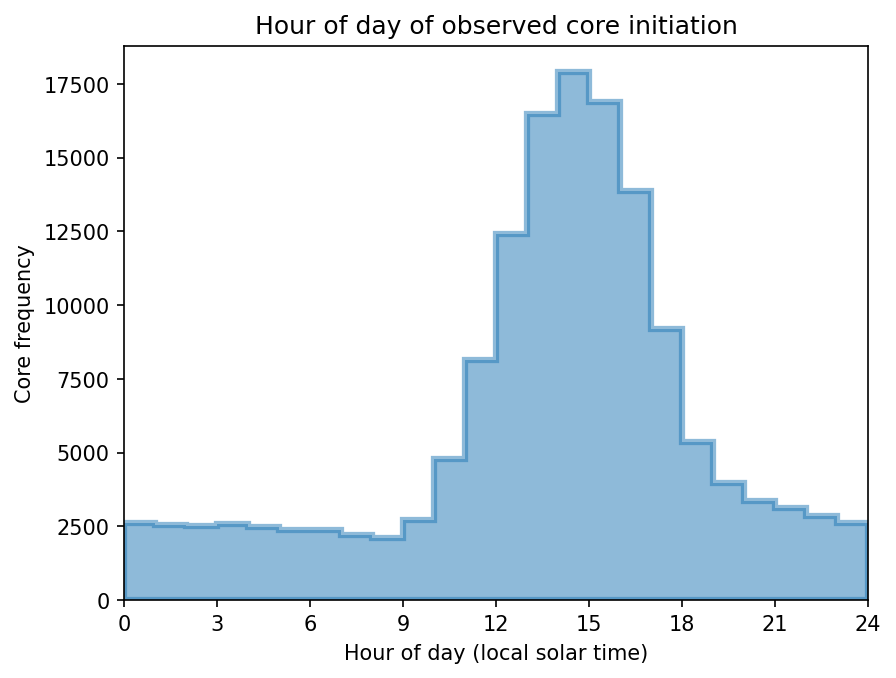

In [6]:
plt.figure(dpi=150)
plt.hist(core_local_hour, bins=range(25), 
         alpha=0.5, facecolor = 'C0', edgecolor='C0', ls='solid', lw=3, histtype='stepfilled')
plt.xlim([0,24])
plt.xticks(range(0,25,3))
plt.xlabel("Hour of day (local solar time)")
plt.ylabel("Core frequency")
plt.title("Hour of day of observed core initiation")


In [7]:
anvil_start_lat = np.concatenate([ds.thick_anvil_start_lat.data for ds in datasets])
anvil_start_lon = np.concatenate([ds.thick_anvil_start_lon.data for ds in datasets])
anvil_start_t = np.concatenate([ds.thick_anvil_start_t.data for ds in datasets])

# Now calculate local (solar) time using latitude
anvil_local_time = np.array([(pd.to_datetime(t).to_pydatetime() + timedelta(hours=anvil_start_lon[i]/15)).time() for i,t in enumerate(anvil_start_t)])

def get_fractional_hour(x):
    return x.hour + x.minute/60 + x.second/3600

anvil_local_hour = np.array([get_fractional_hour(t) for t in anvil_local_time])

In [8]:
anvil_is_valid = np.concatenate([
    np.logical_and(ds.thin_anvil_is_valid.data, ds.thick_anvil_is_valid.data) 
    for ds in datasets
])
np.sum(anvil_is_valid), anvil_is_valid.size

(10070, 10828)

Text(0.5, 1.0, 'Hour of day of observed anvil initiation')

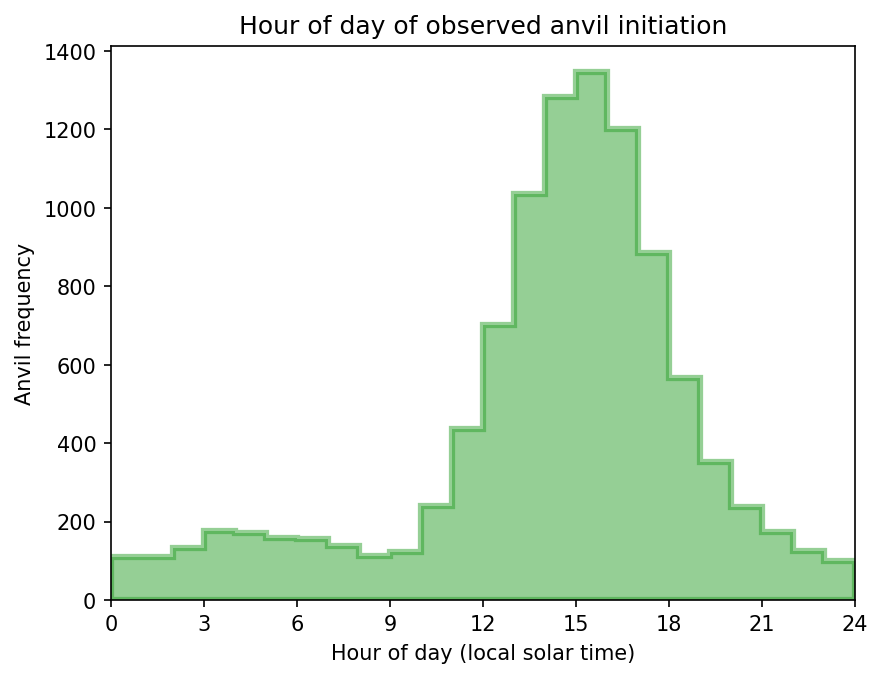

In [9]:
plt.figure(dpi=150)
plt.hist(anvil_local_hour[anvil_is_valid], bins=range(25), 
         alpha=0.5, facecolor = 'C2', edgecolor='C2', ls='solid', lw=3, histtype='stepfilled')
plt.xlim([0,24])
plt.xticks(range(0,25,3))
plt.xlabel("Hour of day (local solar time)")
plt.ylabel("Anvil frequency")
plt.title("Hour of day of observed anvil initiation")


Text(0.5, 1.0, 'Core detection frequency')

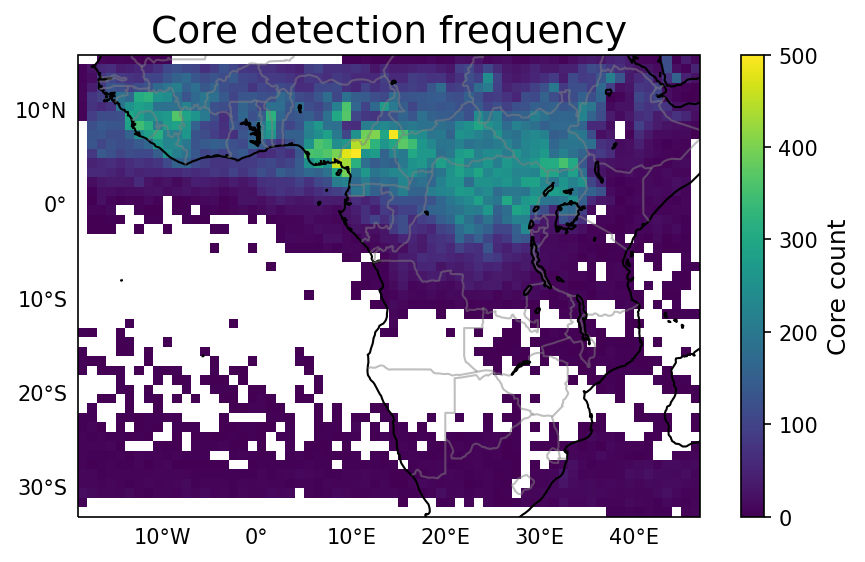

In [10]:
img_extent = (-19, 47, -33, 16)
max_count = 500
min_count = 0

fig = plt.figure(dpi=150, figsize=(7,4))

ax1 = plt.subplot(111, projection=ccrs.PlateCarree())
ax1.coastlines()
ax1.add_feature(cfeature.BORDERS, edgecolor='gray', alpha=0.5)
ax1.add_feature(cfeature.LAKES, edgecolor='black', alpha=1, facecolor="none")
gl = ax1.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                   linewidth=1, color='gray', alpha=0.5, linestyle='--')
gl.top_labels = False
gl.right_labels = False
gl.xlines = False
gl.ylines = False
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER


h = ax1.hist2d(
    core_start_lon, 
   core_start_lat, 
   bins=[np.arange(img_extent[0],img_extent[1]+1), np.arange(img_extent[2],img_extent[3]+1)], 
   cmin=1, vmax=max_count, vmin=min_count
)
cbar = plt.colorbar(h[3])
cbar.set_label("Core count", fontsize=12)
ax1.set_title("Core detection frequency", fontsize=18)

Text(0.5, 1.0, 'Anvil detection frequency')

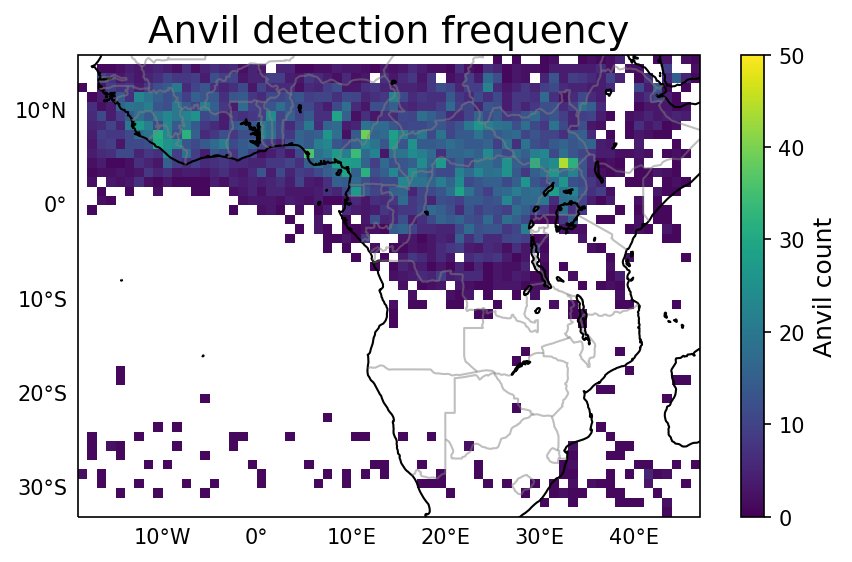

In [11]:
max_count = 50
min_count = 0

fig = plt.figure(dpi=150, figsize=(7,4))

ax1 = plt.subplot(111, projection=ccrs.PlateCarree())
ax1.coastlines()
ax1.add_feature(cfeature.BORDERS, edgecolor='gray', alpha=0.5)
ax1.add_feature(cfeature.LAKES, edgecolor='black', alpha=1, facecolor="none")
gl = ax1.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                   linewidth=1, color='gray', alpha=0.5, linestyle='--')
gl.top_labels = False
gl.right_labels = False
gl.xlines = False
gl.ylines = False
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER


h = ax1.hist2d(anvil_start_lon[anvil_is_valid], 
               anvil_start_lat[anvil_is_valid], 
               bins=[np.arange(img_extent[0],img_extent[1]+1), np.arange(img_extent[2],img_extent[3]+1)], 
               cmin=1, vmax=max_count, vmin=min_count)
cbar = plt.colorbar(h[3])
cbar.set_label("Anvil count", fontsize=12)
ax1.set_title("Anvil detection frequency", fontsize=18)

/tmp/ipykernel_44424/2843748889.py:23: RuntimeWarning: divide by zero encountered in divide
  img = ax.imshow((img_data[0] * (h[0]/(h[0]-1))).T[::-1], extent=img_extent, vmin=0, vmax=18, cmap="Reds")
/tmp/ipykernel_44424/2843748889.py:23: RuntimeWarning: invalid value encountered in multiply
  img = ax.imshow((img_data[0] * (h[0]/(h[0]-1))).T[::-1], extent=img_extent, vmin=0, vmax=18, cmap="Reds")
/tmp/ipykernel_44424/2843748889.py:28: RuntimeWarning: divide by zero encountered in divide
  statistic=circstd_hour)[0] * (h[0]/(h[0]-1))
/tmp/ipykernel_44424/2843748889.py:25: RuntimeWarning: invalid value encountered in multiply
  hatch_data = binned_statistic_2d(core_start_lon, core_start_lat, core_local_hour,


Text(0.5, 1.0, 'Core detection time standard deviation map')

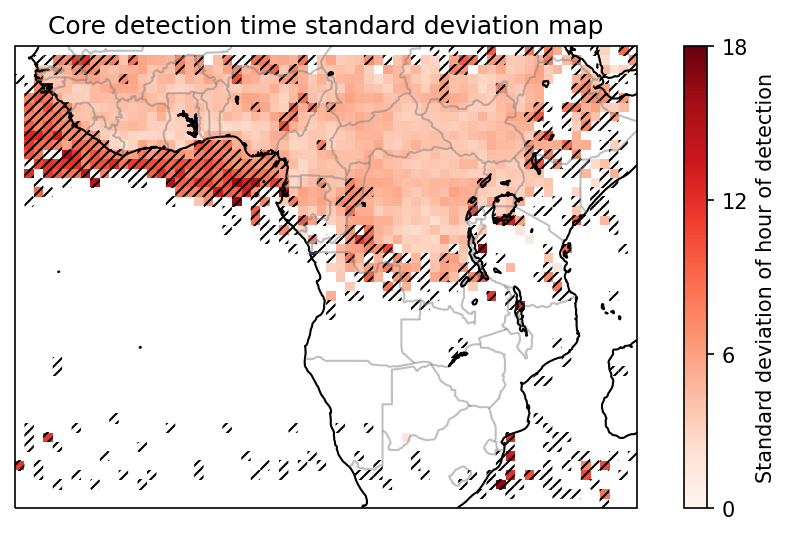

In [12]:
# Figure 10
from scipy.stats import circstd
from scipy.stats import binned_statistic_2d, circmean
from matplotlib import patches

def circstd_hour(x):
    return circstd(x, high=24, low=0)

def get_fractional_hour(x):
    return x.hour + x.minute/60 + x.second/3600

fig = plt.figure(dpi=150, figsize=(8,4))

ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()
ax.add_feature(cfeature.BORDERS, edgecolor='gray', alpha=0.5)
ax.add_feature(cfeature.LAKES, edgecolor='black', alpha=1, facecolor="none")

img_data = binned_statistic_2d(
    core_start_lon, core_start_lat, core_local_hour, 
    bins=[np.arange(img_extent[0],img_extent[1]+1), 
         np.arange(img_extent[2],img_extent[3]+1)], 
    statistic=circstd_hour
)
img = ax.imshow((img_data[0] * (h[0]/(h[0]-1))).T[::-1], extent=img_extent, vmin=0, vmax=18, cmap="Reds")

hatch_data = binned_statistic_2d(
    core_start_lon, core_start_lat, core_local_hour, 
     bins=[np.arange(img_extent[0],img_extent[1]+1), 
           np.arange(img_extent[2],img_extent[3]+1)], 
     statistic=circstd_hour
)[0] * (h[0]/(h[0]-1))

for i in range(hatch_data.shape[0]):
    for j in range(hatch_data.shape[1]):
        if hatch_data[i,j] > 6:
            ax.add_patch(patches.Rectangle((i+img_extent[0], j+img_extent[2]), 1, 1, 
               hatch='/////', fill=False, snap=False, linewidth=0))

cbar = plt.colorbar(img, label="Standard deviation of hour of detection")
cbar.set_ticks([0,6,12,18])

plt.title("Core detection time standard deviation map")

/tmp/ipykernel_44424/2122335971.py:35: RuntimeWarning: divide by zero encountered in divide
  statistic=circstd_hour)[0] * (h[0]/(h[0]-1))
/tmp/ipykernel_44424/2122335971.py:32: RuntimeWarning: invalid value encountered in multiply
  hatch_data = binned_statistic_2d(core_start_lon, core_start_lat, core_local_hour,


Text(0.5, 1.0, 'Core detection time')

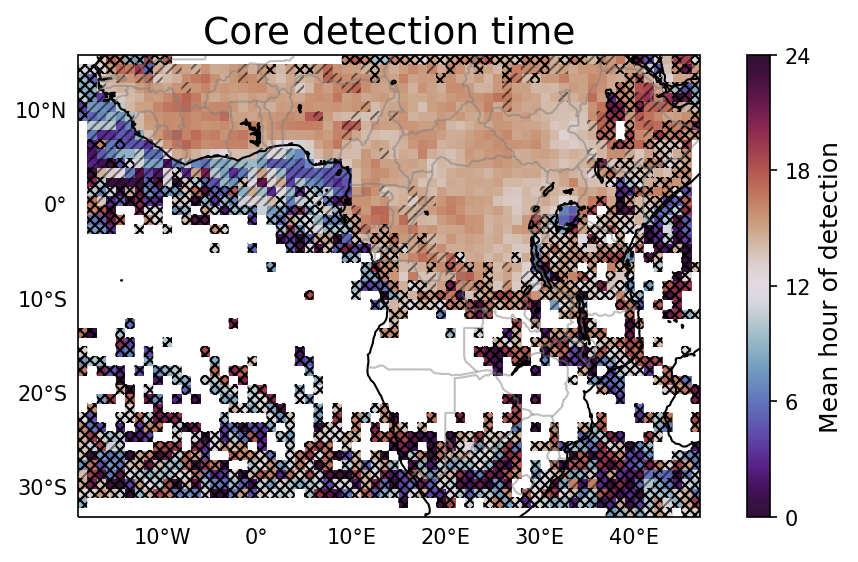

In [13]:
# Figure 10
from scipy.stats import binned_statistic_2d, circmean
from matplotlib import patches

def circmean_hour(x):
    return circmean(x, high=24, low=0)

def get_fractional_hour(x):
    return x.hour + x.minute/60 + x.second/3600

fig = plt.figure(dpi=150, figsize=(8,4))

ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()
ax.add_feature(cfeature.BORDERS, edgecolor='gray', alpha=0.5)
ax.add_feature(cfeature.LAKES, edgecolor='black', alpha=1, facecolor="none")
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                   linewidth=1, color='gray', alpha=0.5, linestyle='--')
gl.top_labels = False
gl.right_labels = False
gl.xlines = False
gl.ylines = False
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER

img_data = binned_statistic_2d(core_start_lon, core_start_lat, core_local_hour, 
                               bins=[np.arange(img_extent[0],img_extent[1]+1), 
                                     np.arange(img_extent[2],img_extent[3]+1)], 
                               statistic=circmean_hour)
img = ax.imshow(img_data[0].T[::-1], extent=img_extent, vmin=0, vmax=24, cmap="twilight_shifted")

hatch_data = binned_statistic_2d(core_start_lon, core_start_lat, core_local_hour, 
                                 bins=[np.arange(img_extent[0],img_extent[1]+1), 
                                       np.arange(img_extent[2],img_extent[3]+1)], 
                                 statistic=circstd_hour)[0] * (h[0]/(h[0]-1))

for i in range(hatch_data.shape[0]):
    for j in range(hatch_data.shape[1]):
        if np.isfinite(img_data[0][i,j]):
            if hatch_data[i,j] > 6 or np.isnan(hatch_data[i,j]):
                ax.add_patch(patches.Rectangle((i+img_extent[0], j+img_extent[2]), 1, 1, 
                   hatch='/////', fill=False, snap=False, linewidth=0, alpha=0.5))
            if hatch_data[i,j] > 12 or np.isnan(hatch_data[i,j]):
                ax.add_patch(patches.Rectangle((i+img_extent[0], j+img_extent[2]), 1, 1, 
                   hatch='/////', fill=False, snap=False, linewidth=0))
                ax.add_patch(patches.Rectangle((i+img_extent[0], j+img_extent[2]), 1, 1, 
                   hatch="\\\\\\\\\\", fill=False, snap=False, linewidth=0))

cbar = plt.colorbar(img)
cbar.set_ticks([0,6,12,18,24])
cbar.set_label("Mean hour of detection", fontsize=12)

plt.title("Core detection time", fontsize=18)

Text(0.5, 1.0, 'Anvil detection time map')

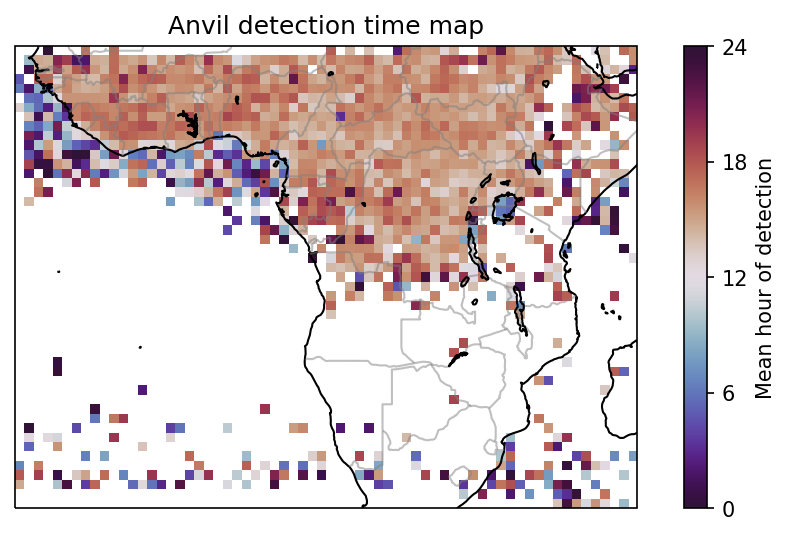

In [15]:
# Figure 10
def circmean_hour(x):
    return circmean(x, high=24, low=0)

def get_fractional_hour(x):
    return x.hour + x.minute/60 + x.second/3600

fig = plt.figure(dpi=150, figsize=(8,4))

ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()
ax.add_feature(cfeature.BORDERS, edgecolor='gray', alpha=0.5)
ax.add_feature(cfeature.LAKES, edgecolor='black', alpha=1, facecolor="none")

from scipy.stats import binned_statistic_2d, circmean

img_data = binned_statistic_2d(anvil_start_lon, anvil_start_lat, anvil_local_hour, 
                               bins=[np.arange(img_extent[0],img_extent[1]+1), 
                                     np.arange(img_extent[2],img_extent[3]+1)], 
                               statistic=circmean_hour)
img = ax.imshow(img_data[0].T[::-1], extent=img_extent, vmin=0, vmax=24, cmap="twilight_shifted")

cbar = plt.colorbar(img, label="Mean hour of detection")
cbar.set_ticks([0,6,12,18,24])

plt.title("Anvil detection time map")

In [16]:
anvil_lat = np.concatenate([ds.thick_anvil_average_lat.data for ds in datasets])
anvil_lon = np.concatenate([ds.thick_anvil_average_lon.data for ds in datasets])


In [17]:
# Find regions
# Get land/sea mask from imerg

lsm_file = "/home/users/wkjones/GPM_IMERG_LandSeaMask.2.nc4"
lsm_ds = xr.open_dataset(lsm_file)

lsm = lsm_ds.landseamask.sel(lon=slice(img_extent[0], img_extent[1]), 
                             lat=slice(img_extent[2], img_extent[3]))

wh_sea = lsm >=100 

# Remove Pacific/Northern regions from sea
wh_sea.loc[img_extent[0]:-105] = False
wh_sea.loc[:, 40:img_extent[3]+1] = False

lsm_distance = ndi.distance_transform_edt(~wh_sea)*9.6
wh_coastal = xr.zeros_like(wh_sea)
wh_coastal.data = ndi.binary_opening(np.logical_and(lsm_distance<=200, ~wh_sea))
wh_coastal.loc[img_extent[0]:-105] = False
wh_coastal.loc[:, 40:img_extent[3]+1] = False

lsm_distance_ds = xr.zeros_like(wh_sea)
lsm_distance_ds.data = lsm_distance_ds.data.astype(float)
lsm_distance_ds.data = lsm_distance

core_lsm_distance = lsm_distance_ds.sel(lon=xr.DataArray(core_start_lon, dims="points"), 
                                        lat=xr.DataArray(core_start_lat, dims="points"), 
                                        method="nearest").data

anvil_lsm_distance = lsm_distance_ds.sel(lon=xr.DataArray(anvil_lon, dims="points"), 
                                        lat=xr.DataArray(anvil_lat, dims="points"), 
                                        method="nearest").data

In [18]:
anvil_is_valid = np.logical_and(anvil_is_valid, anvil_lat > -15)

In [19]:
anvil_is_land = np.logical_and(
    anvil_is_valid, 
    anvil_lsm_distance > 0
)

In [21]:
np.sum(anvil_is_valid), np.sum(anvil_is_land)

(9924, 9039)

Text(0.5, 1.0, 'Frequency of anvils by number of cores')

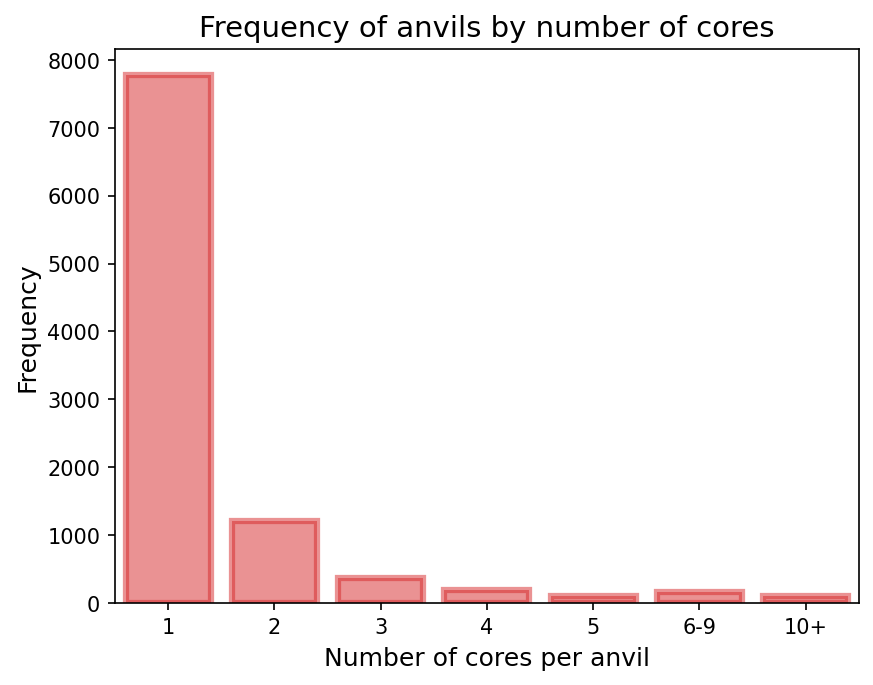

In [22]:
from scipy.stats import binned_statistic

anvil_number_of_cores = np.concatenate([ds.anvil_core_count.data for ds in datasets])
bins = [0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 9.5, 999999]
bin_positions = [1, 2, 3, 4, 5, 6, 7]
bin_labels = [1, 2, 3, 4, 5, "6-9", "10+"]

bar_data = binned_statistic(
    anvil_number_of_cores[anvil_is_valid], 
    np.ones(anvil_number_of_cores.size)[anvil_is_valid], 
    bins=bins, 
    statistic="sum"
)

plt.figure(dpi=150)
plt.bar(bin_positions, bar_data[0], 
        alpha=0.5, facecolor = 'C3', edgecolor='C3', ls='solid', lw=3)

plt.xlim([0.5, 7.5])
plt.xticks(bin_positions, bin_labels)
plt.xlabel("Number of cores per anvil", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.title("Frequency of anvils by number of cores", fontsize=14)

In [23]:
anvil_number_of_cores[anvil_is_valid].argmax()

2504

In [24]:
anvil_number_of_cores[anvil_is_valid][2504]

363

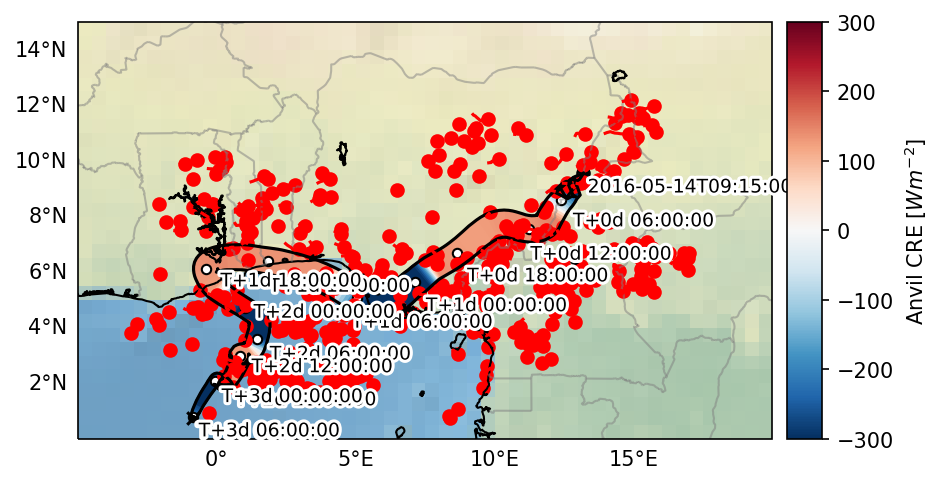

In [259]:
from matplotlib import patheffects, colors
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable

def strfdelta(tdelta, fmt='{D:02}d {H:02}h {M:02}m {S:02}s', inputtype='timedelta'):
    """Convert a datetime.timedelta object or a regular number to a custom-
    formatted string, just like the stftime() method does for datetime.datetime
    objects.

    The fmt argument allows custom formatting to be specified.  Fields can 
    include seconds, minutes, hours, days, and weeks.  Each field is optional.

    Some examples:
        '{D:02}d {H:02}h {M:02}m {S:02}s' --> '05d 08h 04m 02s' (default)
        '{W}w {D}d {H}:{M:02}:{S:02}'     --> '4w 5d 8:04:02'
        '{D:2}d {H:2}:{M:02}:{S:02}'      --> ' 5d  8:04:02'
        '{H}h {S}s'                       --> '72h 800s'

    The inputtype argument allows tdelta to be a regular number instead of the  
    default, which is a datetime.timedelta object.  Valid inputtype strings: 
        's', 'seconds', 
        'm', 'minutes', 
        'h', 'hours', 
        'd', 'days', 
        'w', 'weeks'
    """
    from string import Formatter
    
    # Convert tdelta to integer seconds.
    if inputtype == 'timedelta':
        remainder = int(tdelta.total_seconds())
    elif inputtype in ['s', 'seconds']:
        remainder = int(tdelta)
    elif inputtype in ['m', 'minutes']:
        remainder = int(tdelta)*60
    elif inputtype in ['h', 'hours']:
        remainder = int(tdelta)*3600
    elif inputtype in ['d', 'days']:
        remainder = int(tdelta)*86400
    elif inputtype in ['w', 'weeks']:
        remainder = int(tdelta)*604800

    f = Formatter()
    desired_fields = [field_tuple[1] for field_tuple in f.parse(fmt)]
    possible_fields = ('W', 'D', 'H', 'M', 'S')
    constants = {'W': 604800, 'D': 86400, 'H': 3600, 'M': 60, 'S': 1}
    values = {}
    for field in possible_fields:
        if field in desired_fields and field in constants:
            values[field], remainder = divmod(remainder, constants[field])
    return f.format(fmt, **values)

def add_anvil_track(dataset, anvil, ax, annotate=False):
    markersize=6
    fontsize=9
    
    wh_thick_anvil_step = np.isin(dataset.thick_anvil_step_anvil_index.data, anvil)
    n_steps = np.sum(wh_thick_anvil_step)
    rolling_steps = np.minimum(np.maximum(n_steps//4, 3), 12)
    
    smooth_lat = dataset.thick_anvil_step_lat[wh_thick_anvil_step].rolling(
        thick_anvil_step=rolling_steps, center=True, min_periods=1
    ).reduce(np.nanmean) 
    smooth_lon = dataset.thick_anvil_step_lon[wh_thick_anvil_step].rolling(
        thick_anvil_step=rolling_steps, center=True, min_periods=1
    ).reduce(np.nanmean)
    smooth_area = dataset.thick_anvil_step_area[wh_thick_anvil_step].rolling(
        thick_anvil_step=rolling_steps, center=True, min_periods=1
    ).reduce(np.nanmean)
    anvil_cre = dataset.thick_anvil_step_toa_cre_mean[wh_thick_anvil_step]
    
    grad = np.stack([-np.gradient(smooth_lat), np.gradient(smooth_lon)])
    grad /= (np.sum(grad**2, 0)**0.5)
    offsets = 2**np.log10(smooth_area.data / 1000) * grad / 12
    offsets[:, 0] = 0
    offsets[:, -1] = 0
    
    ax.plot(smooth_lon+offsets[0], smooth_lat+offsets[1], "k")
    ax.plot(smooth_lon-offsets[0], smooth_lat-offsets[1], "k")

    args = []
    for i in range(smooth_lon.size-1):
        xf = np.concatenate(
            [smooth_lon[i:i+2]+offsets[0,i:i+2], (smooth_lon[i:i+2]-offsets[0,i:i+2])[::-1]]
        )
        yf = np.concatenate(
            [smooth_lat[i:i+2]+offsets[1,i:i+2], (smooth_lat[i:i+2]-offsets[1,i:i+2])[::-1]]
        )
        cf = plt.cm.RdBu_r(np.maximum(np.minimum(anvil_cre[i].item()+300, 600), 0)/600)
        args.append([xf, yf, cf])

    for arg in args:
        ax.fill(arg[0], arg[1], color=arg[2])
    ax.scatter(
        smooth_lon[0].item(), 
        smooth_lat[0].item(), 
        c="k", s=markersize**2
    )
    ax.scatter(
        smooth_lon[-1].item(), 
        smooth_lat[-1].item(), 
        c="k", marker="x", s=markersize**2
    )
    start_dt = pd.to_datetime(dataset.thick_anvil_start_t.loc[anvil].data).to_pydatetime()
    end_dt = pd.to_datetime(dataset.thick_anvil_end_t.loc[anvil].data).to_pydatetime()
    lifetime = end_dt - start_dt
    
    if annotate:
        ax.text(
            smooth_lon[0].item()+0.15, 
            smooth_lat[0].item()-0.15, 
            start_dt.isoformat(), 
            va="top", fontsize=fontsize, 
            path_effects=[patheffects.withStroke(linewidth=3, foreground="w")]
        )
        ax.text(
            smooth_lon[-1].item()+0.15, 
            smooth_lat[-1].item()-0.15, 
            strfdelta(lifetime, "T+{D}d {H:02}:{M:02}:{S:02}"), 
            va="top", fontsize=fontsize, 
            path_effects=[patheffects.withStroke(linewidth=3, foreground="w")]
        )
    
        if lifetime.total_seconds()/3600 > 13:
            time_ticks = [timedelta(hours=i) for i in np.arange(6, lifetime.total_seconds()/3600-0.99, 6)]
        elif lifetime.total_seconds()/3600 > 4:
            time_ticks = [timedelta(hours=i) for i in np.arange(3, lifetime.total_seconds()/3600-0.99, 3)]
        else:
            time_ticks = []
        
        if len(time_ticks) > 0 and time_ticks[-1].days >= 1:
            fmtstr = "T+{D}d {H:02}:{M:02}:{S:02}"
        else:
            fmtstr = "T+{H:02}:{M:02}:{S:02}"

        for time in time_ticks:
            wh = np.abs(
                dataset.thick_anvil_step_t[wh_thick_anvil_step] 
                - np.datetime64(start_dt+time)
            ).argmin().item()

            ax.scatter(
                smooth_lon[wh], smooth_lat[wh], marker="o", 
                s=(markersize*0.75)**2, facecolor="white", edgecolor="k"
            )
            
            ax.text(
                smooth_lon[wh]+offsets[0][wh]+0.1, smooth_lat[wh]+offsets[1][wh]-0.1, 
                strfdelta(time, fmtstr), 
                va="top", fontsize=fontsize, 
                path_effects=[patheffects.withStroke(linewidth=3, foreground="w")]
            )


fig = plt.figure(dpi=150)
ax = plt.subplot(111, projection=ccrs.PlateCarree())
img_extent = [-5, 20, 0, 15]
ax.set_extent(img_extent, ccrs.PlateCarree())
ax.stock_img()
ax.coastlines()
ax.add_feature(cfeature.BORDERS, edgecolor='gray', alpha=0.5)
ax.add_feature(cfeature.LAKES, edgecolor='black', alpha=1, facecolor="none")
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=1, color='gray', alpha=0.5, linestyle='--')
gl.top_labels = False
gl.right_labels = False
gl.xlines = False
gl.ylines = False
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER


anvils = [anvil]

for anv in anvils:
    add_anvil_track(dataset, anv, ax, annotate=True)

core = dataset.core[dataset.core_anvil_index.data==anvil]
wh_core_step = np.isin(dataset.core_step_core_index.data, core)

ax.scatter(dataset.core_start_lon.loc[core], dataset.core_start_lat.loc[core], c="r")
for c in core:
    ax.plot(
        dataset.core_step_lon[dataset.core_step_core_index==c].rolling(core_step=3, center=True, min_periods=1).reduce(np.nanmean), 
        dataset.core_step_lat[dataset.core_step_core_index==c].rolling(core_step=3, center=True, min_periods=1).reduce(np.nanmean), 
        "r-"
    )
# plt.title("DCC Tracks 2018/06/13", fontweight="bold")

cbar_size="5%"
cbar_pad=0.1
ax_divider = make_axes_locatable(ax)
cax_r = ax_divider.new_horizontal(size=cbar_size, pad=cbar_pad, axes_class=plt.Axes)
fig.add_axes(cax_r)

norm = colors.Normalize(vmin=-300,vmax=300)
sm = plt.cm.ScalarMappable(cmap="RdBu_r", norm=norm)
sm.set_array([])
plt.colorbar(sm, cax=cax_r, label="Anvil CRE [$Wm^{-2}$]")


In [26]:
core_max_ctt = np.concatenate([ds.core_step_ctt_mean.groupby(ds.core_step_core_index).max() for ds in datasets])

In [27]:
np.sum(core_max_ctt>273), core_max_ctt.size

(38211, 145463)

In [28]:
core_maxmax_ctt = np.concatenate([ds.core_step_ctt_max.groupby(ds.core_step_core_index).max() for ds in datasets])

In [29]:
np.sum(core_maxmax_ctt>273), core_max_ctt.size

(69686, 145463)

Text(0.5, 1.0, 'Core detection frequency')

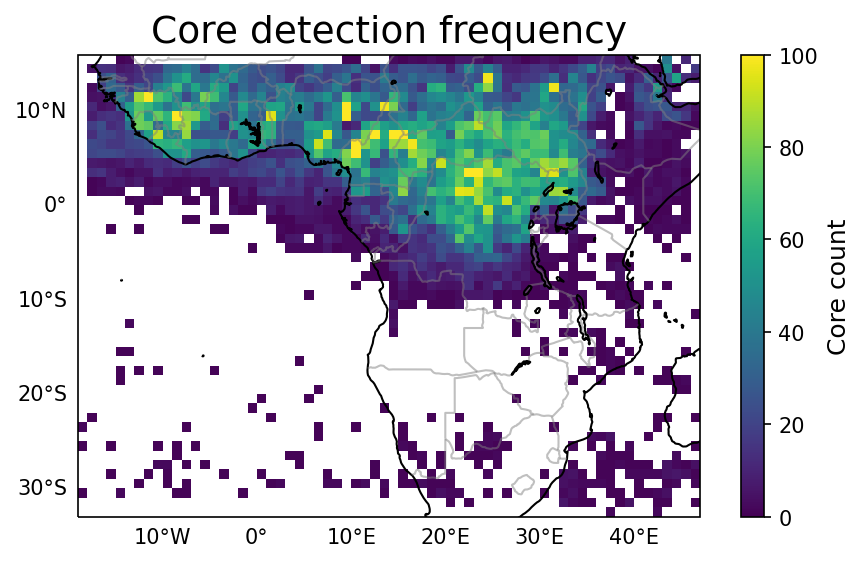

In [30]:
img_extent = (-19, 47, -33, 16)
max_count = 100
min_count = 0

fig = plt.figure(dpi=150, figsize=(7,4))

ax1 = plt.subplot(111, projection=ccrs.PlateCarree())
ax1.coastlines()
ax1.add_feature(cfeature.BORDERS, edgecolor='gray', alpha=0.5)
ax1.add_feature(cfeature.LAKES, edgecolor='black', alpha=1, facecolor="none")
gl = ax1.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                   linewidth=1, color='gray', alpha=0.5, linestyle='--')
gl.top_labels = False
gl.right_labels = False
gl.xlines = False
gl.ylines = False
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER


h = ax1.hist2d(core_start_lon[core_max_ctt>273], 
               core_start_lat[core_max_ctt>273], 
               bins=[np.arange(img_extent[0],img_extent[1]+1), np.arange(img_extent[2],img_extent[3]+1)], 
               cmin=1, vmax=max_count, vmin=min_count)
cbar = plt.colorbar(h[3])
cbar.set_label("Core count", fontsize=12)
ax1.set_title("Core detection frequency", fontsize=18)

/tmp/ipykernel_14993/4221472997.py:39: RuntimeWarning: divide by zero encountered in divide
  statistic=circstd_hour)[0] * (h[0]/(h[0]-1))
/tmp/ipykernel_14993/4221472997.py:34: RuntimeWarning: invalid value encountered in multiply
  hatch_data = binned_statistic_2d(core_start_lon[core_max_ctt>273],


Text(0.5, 1.0, 'Core detection time')

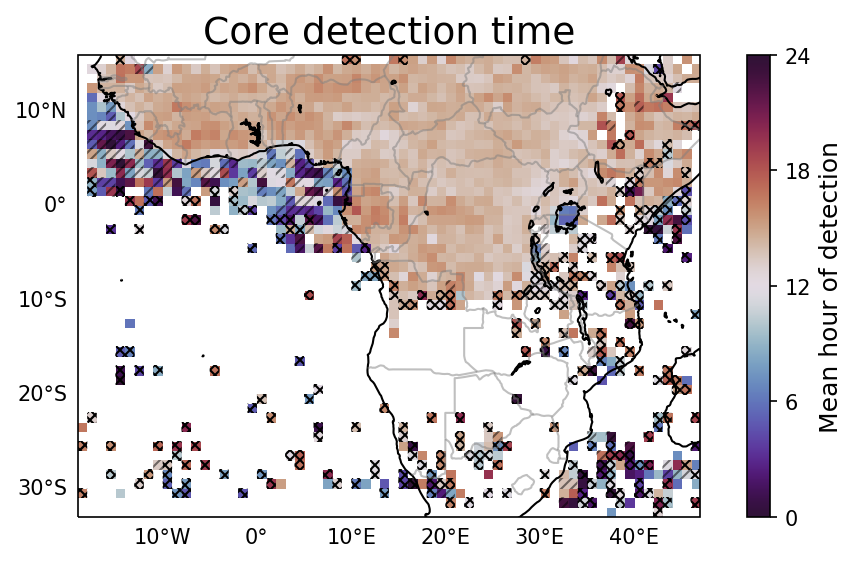

In [31]:
# Figure 10
from scipy.stats import binned_statistic_2d, circmean
from matplotlib import patches

def circmean_hour(x):
    return circmean(x, high=24, low=0)

def get_fractional_hour(x):
    return x.hour + x.minute/60 + x.second/3600

fig = plt.figure(dpi=150, figsize=(8,4))

ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()
ax.add_feature(cfeature.BORDERS, edgecolor='gray', alpha=0.5)
ax.add_feature(cfeature.LAKES, edgecolor='black', alpha=1, facecolor="none")
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                   linewidth=1, color='gray', alpha=0.5, linestyle='--')
gl.top_labels = False
gl.right_labels = False
gl.xlines = False
gl.ylines = False
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER

img_data = binned_statistic_2d(core_start_lon[core_max_ctt>273], 
                               core_start_lat[core_max_ctt>273], 
                               core_local_hour[core_max_ctt>273], 
                               bins=[np.arange(img_extent[0],img_extent[1]+1), 
                                     np.arange(img_extent[2],img_extent[3]+1)], 
                               statistic=circmean_hour)
img = ax.imshow(img_data[0].T[::-1], extent=img_extent, vmin=0, vmax=24, cmap="twilight_shifted")

hatch_data = binned_statistic_2d(core_start_lon[core_max_ctt>273], 
                                 core_start_lat[core_max_ctt>273], 
                                 core_local_hour[core_max_ctt>273], 
                                 bins=[np.arange(img_extent[0],img_extent[1]+1), 
                                       np.arange(img_extent[2],img_extent[3]+1)], 
                                 statistic=circstd_hour)[0] * (h[0]/(h[0]-1))

for i in range(hatch_data.shape[0]):
    for j in range(hatch_data.shape[1]):
        if np.isfinite(img_data[0][i,j]):
            if hatch_data[i,j] > 6:
                ax.add_patch(patches.Rectangle((i+img_extent[0], j+img_extent[2]), 1, 1, 
                   hatch='/////', fill=False, snap=False, linewidth=0, alpha=0.5))
            if hatch_data[i,j] > 12 or np.isnan(hatch_data[i,j]):
                ax.add_patch(patches.Rectangle((i+img_extent[0], j+img_extent[2]), 1, 1, 
                   hatch='/////', fill=False, snap=False, linewidth=0))
                ax.add_patch(patches.Rectangle((i+img_extent[0], j+img_extent[2]), 1, 1, 
                   hatch="\\\\\\\\\\", fill=False, snap=False, linewidth=0))

cbar = plt.colorbar(img)
cbar.set_ticks([0,6,12,18,24])
cbar.set_label("Mean hour of detection", fontsize=12)

plt.title("Core detection time", fontsize=18)

In [309]:
anvil_coord = np.concatenate([ds.anvil for ds in datasets])
core_anvil_index = np.concatenate([ds.core_anvil_index for ds in datasets])

In [310]:
anvil_core_count = np.asarray(
    [np.sum(core_anvil_index[core_max_ctt>273] == i) for i in anvil_coord]
)


In [311]:
anvil_core_count.max()

140

Text(0.5, 1.0, 'Frequency of anvils by number of cores')

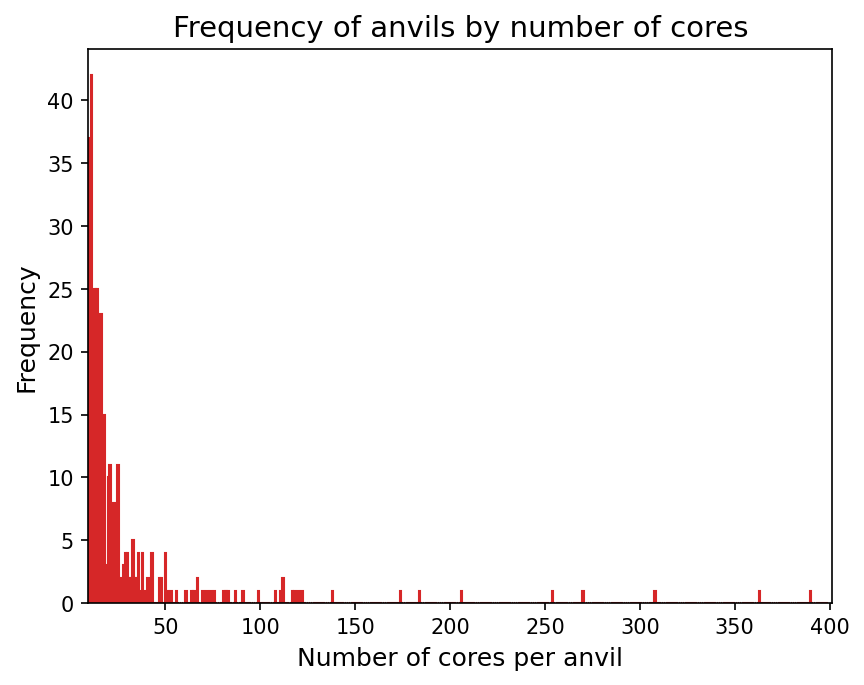

In [366]:
from scipy.stats import binned_statistic

anvil_number_of_cores = np.concatenate([ds.anvil_core_count.data for ds in datasets])
bins = np.arange(10,401)-0.5
bin_positions = np.arange(10,400)
bin_labels = np.arange(10,400)

bar_data = binned_statistic(
    anvil_number_of_cores[anvil_is_valid], 
    np.ones(anvil_core_count.size)[anvil_is_valid], 
    bins=bins, 
    statistic="sum"
)

plt.figure(dpi=150)
plt.bar(bin_positions, bar_data[0], 
        alpha=1, facecolor = 'C3', edgecolor='C3', ls='solid', lw=1)

plt.xlim([9.5, 401.5])
# plt.xticks(bin_positions, bin_labels)
plt.xlabel("Number of cores per anvil", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.title("Frequency of anvils by number of cores", fontsize=14)

Text(0.5, 1.0, 'Frequency of anvils by number of cores')

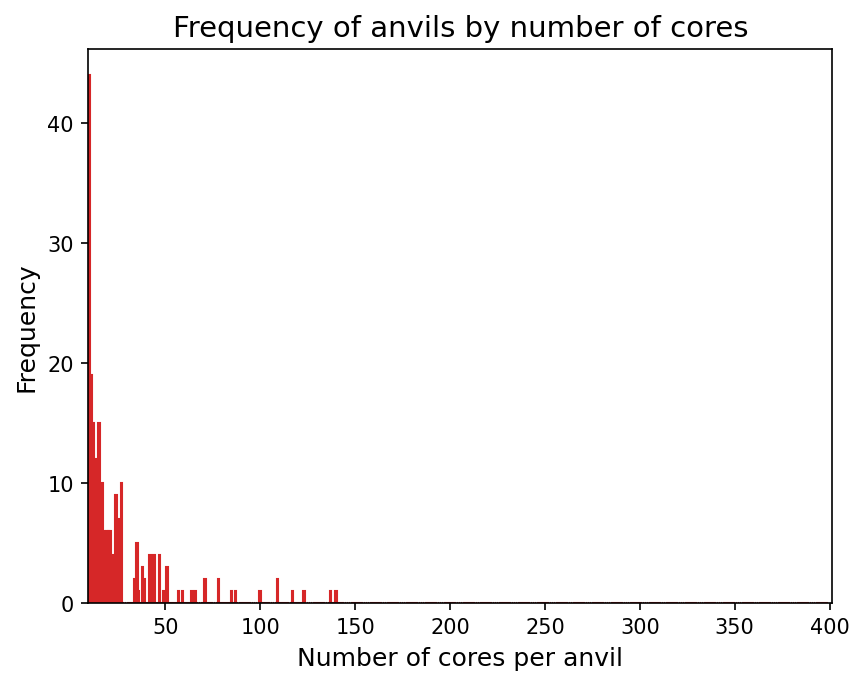

In [365]:
from scipy.stats import binned_statistic

anvil_number_of_cores = np.concatenate([ds.anvil_core_count.data for ds in datasets])
bins = np.arange(10,401)-0.5
bin_positions = np.arange(10,400)
bin_labels = np.arange(10,400)

bar_data = binned_statistic(
    anvil_core_count[anvil_is_valid], 
    np.ones(anvil_core_count.size)[anvil_is_valid], 
    bins=bins, 
    statistic="sum"
)

plt.figure(dpi=150)
plt.bar(bin_positions, bar_data[0], 
        alpha=1, facecolor = 'C3', edgecolor='C3', ls='solid', lw=1)

plt.xlim([9.5, 401.5])
# plt.xticks(bin_positions, bin_labels)
plt.xlabel("Number of cores per anvil", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.title("Frequency of anvils by number of cores", fontsize=14)

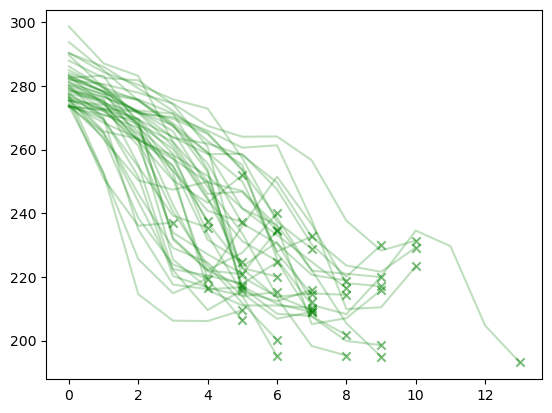

In [320]:
for c in core:
    core_step_ctt = dataset.core_step_ctt_mean[dataset.core_step_core_index==c]
    if core_step_ctt[0] > 273:
        plt.plot(core_step_ctt, "g", alpha=0.25)
        plt.scatter(len(core_step_ctt)-1, core_step_ctt[-1], c="g", marker="x", alpha=0.5)
# plt.title("DCC Tracks 2018/06/13", fontweight="bold")


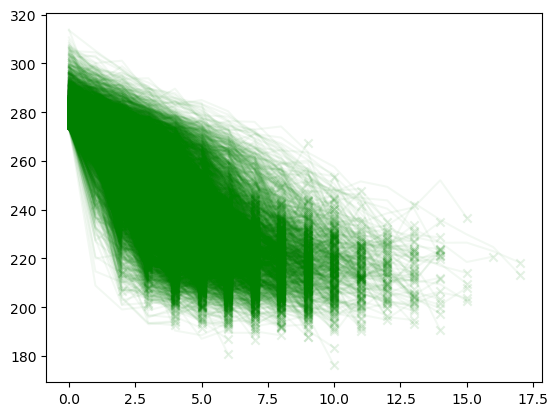

In [321]:
for c in dataset.core:
    core_step_ctt = dataset.core_step_ctt_mean[dataset.core_step_core_index==c]
    if core_step_ctt[0] > 273:
        plt.plot(core_step_ctt, "g", alpha=0.05)
        plt.scatter(len(core_step_ctt)-1, core_step_ctt[-1], c="g", marker="x", alpha=0.1)
# plt.title("DCC Tracks 2018/06/13", fontweight="bold")


In [257]:
np.sum(dataset.core_lifetime.loc[core].data.astype("timedelta64[s]").astype(int)/3600 < 1)

177

In [251]:
core_lifetime = np.concatenate([ds.core_lifetime.data for ds in datasets]).astype("timedelta64[s]").astype(int)/3600
np.sum(core_lifetime<0.5)

4892

In [253]:
np.sum(core_lifetime<0.7)

20409

In [258]:
np.sum(core_lifetime<1)

39697

In [231]:
np.sort(anvil_number_of_cores[anvil_is_valid])[-20:]

array([ 99, 108, 111, 112, 112, 117, 118, 120, 122, 124, 138, 164, 174,
       184, 206, 254, 270, 308, 363, 390])

In [263]:
anvil_lifetime[anvil_is_valid][np.argsort(anvil_number_of_cores[anvil_is_valid])[-20:]]/24

array([1.14583333, 1.45833333, 1.69791667, 1.14583333, 1.33333333,
       1.41666667, 0.83333333, 2.5625    , 1.65625   , 1.80208333,
       1.19791667, 2.44791667, 0.82291667, 1.98958333, 1.69791667,
       2.38541667, 2.32291667, 1.64583333, 3.27083333, 3.35416667])

In [235]:
anvil_max_area[anvil_is_valid][np.argsort(anvil_number_of_cores[anvil_is_valid])[-20:]]

array([196150.72, 193144.23, 293707.06, 389864.66, 161784.89, 298220.44,
       222599.81, 417677.66, 283230.62, 508425.22, 392061.44, 347536.25,
       373525.7 , 310998.66, 517268.94, 527414.2 , 692483.6 , 577369.7 ,
       622699.3 , 449228.22], dtype=float32)

In [324]:
anvil_coord = np.concatenate([ds.anvil for ds in datasets])
core_anvil_index = np.concatenate([ds.core_anvil_index for ds in datasets])
warm_anvil_core_count = np.asarray(
    [np.sum(core_anvil_index[core_max_ctt>273] == i) for i in anvil_coord]
)
anvil_is_valid = np.logical_and(anvil_is_valid, warm_anvil_core_count>0)

In [362]:
(np.sum(anvil_is_valid), anvil_is_valid.size)

(22532, 44194)

In [326]:
np.sort(warm_anvil_core_count[anvil_is_valid])[-20:], anvil_lifetime[anvil_is_valid][np.argsort(warm_anvil_core_count[anvil_is_valid])[-20:]]/24, anvil_max_area[anvil_is_valid][np.argsort(warm_anvil_core_count[anvil_is_valid])[-20:]]

(array([ 51,  51,  51,  57,  59,  64,  66,  71,  71,  78,  78,  85,  87,
        100, 109, 109, 117, 123, 137, 140]),
 array([0.03125   , 0.19791667, 0.83333333, 0.08333333, 0.01041667,
        0.04166667, 0.375     , 0.19791667, 2.32291667, 0.1875    ,
        1.64583333, 3.27083333, 0.35416667, 0.0625    , 0.11458333,
        0.02083333, 0.125     , 0.01041667, 0.01041667, 0.01041667]),
 array([2.85739929e+02, 2.82607178e+03, 2.22599812e+05, 1.73684033e+03,
        3.81959198e+02, 6.12635132e+02, 1.48354277e+04, 4.20643066e+03,
        6.92483625e+05, 2.94624951e+03, 5.77369688e+05, 6.22699312e+05,
        9.70344531e+03, 1.76811316e+03, 1.85408801e+03, 2.20748398e+02,
        1.70825684e+03, 4.93001465e+02, 1.73603485e+02, 1.17764465e+02],
       dtype=float32))

Text(0.5, 1.0, 'Frequency of anvils by number of cores')

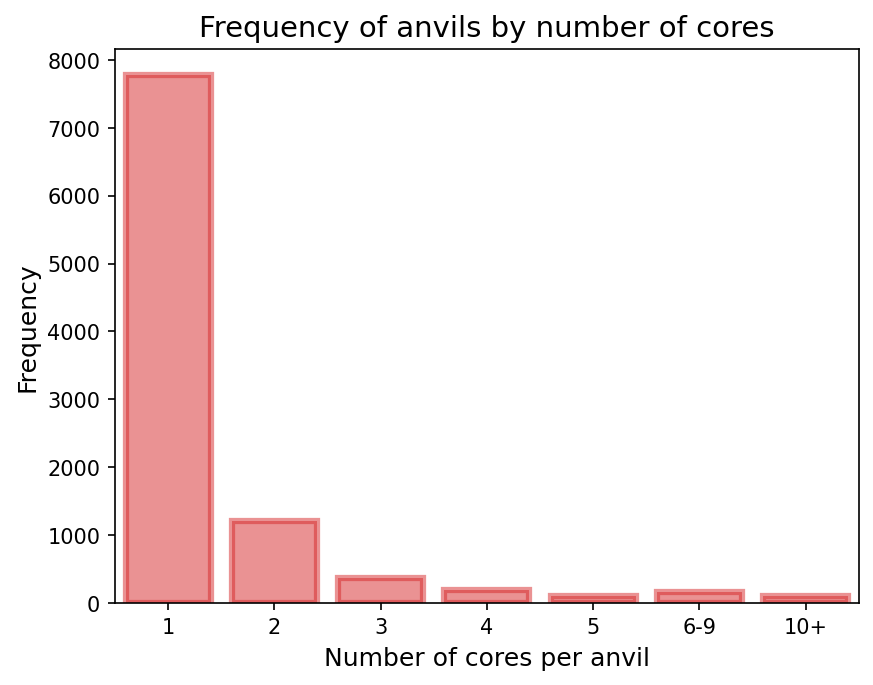

In [32]:
from scipy.stats import binned_statistic

anvil_number_of_cores = np.concatenate([ds.anvil_core_count.data for ds in datasets])
bins = [0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 9.5, 999999]
bin_positions = [1, 2, 3, 4, 5, 6, 7]
bin_labels = [1, 2, 3, 4, 5, "6-9", "10+"]

bar_data = binned_statistic(
    anvil_number_of_cores[anvil_is_valid], 
    np.ones(anvil_number_of_cores.size)[anvil_is_valid], 
    bins=bins, 
    statistic="sum"
)

plt.figure(dpi=150)
plt.bar(bin_positions, bar_data[0], 
        alpha=0.5, facecolor = 'C3', edgecolor='C3', ls='solid', lw=3)

plt.xlim([0.5, 7.5])
plt.xticks(bin_positions, bin_labels)
plt.xlabel("Number of cores per anvil", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.title("Frequency of anvils by number of cores", fontsize=14)

In [33]:
bins

[0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 9.5, 999999]

In [37]:
np.unique(np.digitize(anvil_number_of_cores[anvil_is_valid], bins))

array([1, 2, 3, 4, 5, 6, 7])

In [ ]:
from tobac_flow.utils import combined_std_groupby, weighted_average_uncertainty_groupby, counts_groupby
def get_combined_error_bins(dataset, )
    std_da = combined_std_groupby(
        dataset[var],
        dataset[mean_var],
        dataset.thin_anvil_step_area,
        dataset.thin_anvil_step_anvil_index,
        dataset.anvil,
    )
    uncertainty_da = weighted_average_uncertainty_groupby(
        dataset[var],
        dataset.thin_anvil_step_area,
        dataset.thin_anvil_step_anvil_index,
        dataset.anvil,
    )
    counts_da = counts_groupby(
        dataset.thin_anvil_step_anvil_index, dataset.anvil
    )
    combined_error = (
        (std_da / counts_da**0.5) ** 2
        + uncertainty_da**2
    ) ** 0.5

In [ ]:
dataset.thin_anvil_

Text(0.5, 1.0, 'Average anvil maximum area by number of cores')

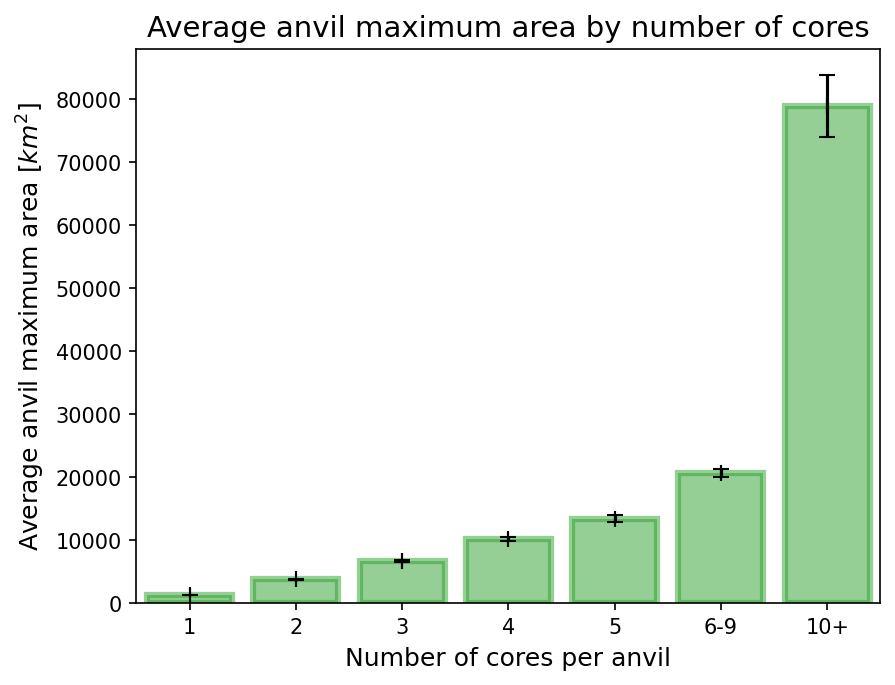

In [329]:
anvil_max_area = np.concatenate([ds.thick_anvil_max_area.data for ds in datasets])

bar_data = binned_statistic(
    anvil_number_of_cores[anvil_is_valid], 
    anvil_max_area[anvil_is_valid], 
    bins=bins, 
    statistic="mean"
)

errorbar_data = binned_statistic(
    anvil_number_of_cores[anvil_is_valid], 
    anvil_max_area[anvil_is_valid], 
    bins=bins, 
    statistic="std"
)

counts = np.histogram(anvil_number_of_cores[anvil_is_valid], bins=bins)

errorbars = errorbar_data[0] / (counts[0])**0.5

plt.figure(dpi=150)
plt.bar(bin_positions, bar_data[0], 
        alpha=0.5, facecolor = 'C2', edgecolor='C2', ls='solid', lw=3)
plt.errorbar(bin_positions, bar_data[0], errorbars, 0, 
             color="k", linestyle="", capsize=4)

plt.xlim([0.5,7.5])
plt.xticks(bin_positions, bin_labels)
plt.xlabel("Number of cores per anvil", fontsize=12)
plt.ylabel("Average anvil maximum area [$km^2$]", fontsize=12)
plt.title("Average anvil maximum area by number of cores", fontsize=14)

Text(0.5, 1.0, 'Average anvil lifetime by number of cores')

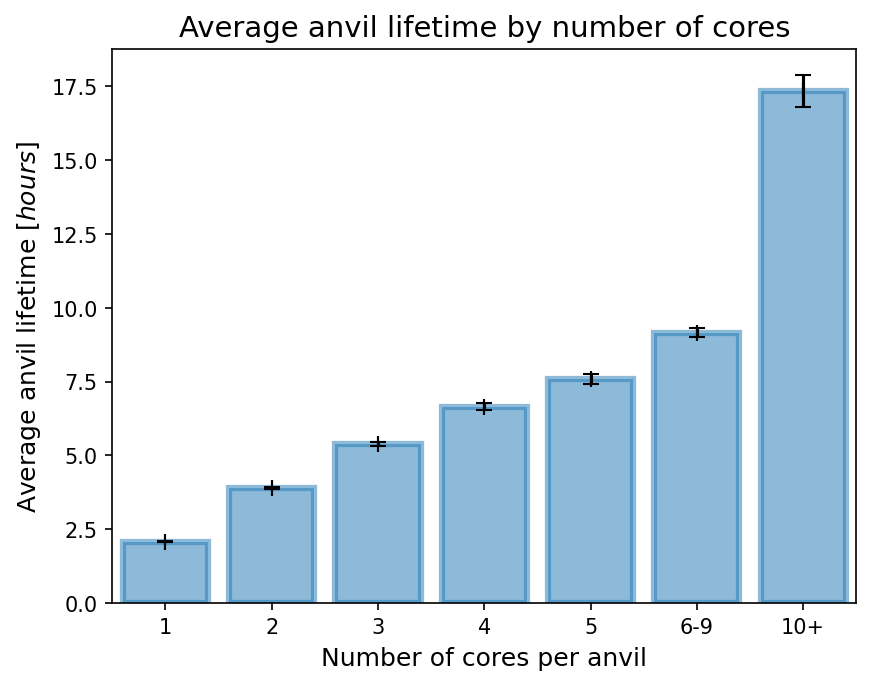

In [330]:
from scipy.stats import binned_statistic

anvil_lifetime = np.concatenate([ds.thick_anvil_lifetime.data for ds in datasets]).astype("timedelta64[s]").astype(int)/3600

bar_data = binned_statistic(
    anvil_number_of_cores[anvil_is_valid], 
    anvil_lifetime[anvil_is_valid], 
    bins=bins, 
    statistic="mean"
)

errorbar_data = binned_statistic(
    anvil_number_of_cores[anvil_is_valid], 
    anvil_lifetime[anvil_is_valid], 
    bins=bins, 
    statistic="std"
)

counts = np.histogram(anvil_number_of_cores[anvil_is_valid], bins=bins)

errorbars = errorbar_data[0] / (counts[0])**0.5

plt.figure(dpi=150)
plt.bar(bin_positions, bar_data[0], 
        alpha=0.5, facecolor = 'C0', edgecolor='C0', ls='solid', lw=3)
plt.errorbar(bin_positions, bar_data[0], errorbars, 0, 
             color="k", linestyle="", capsize=4)

plt.xlim([0.5,7.5])
plt.xticks(bin_positions, bin_labels)
plt.xlabel("Number of cores per anvil", fontsize=12)
plt.ylabel("Average anvil lifetime [$hours$]", fontsize=12)
plt.title("Average anvil lifetime by number of cores", fontsize=14)

Text(0.5, 1.0, 'Anvil coverage by number of cores')

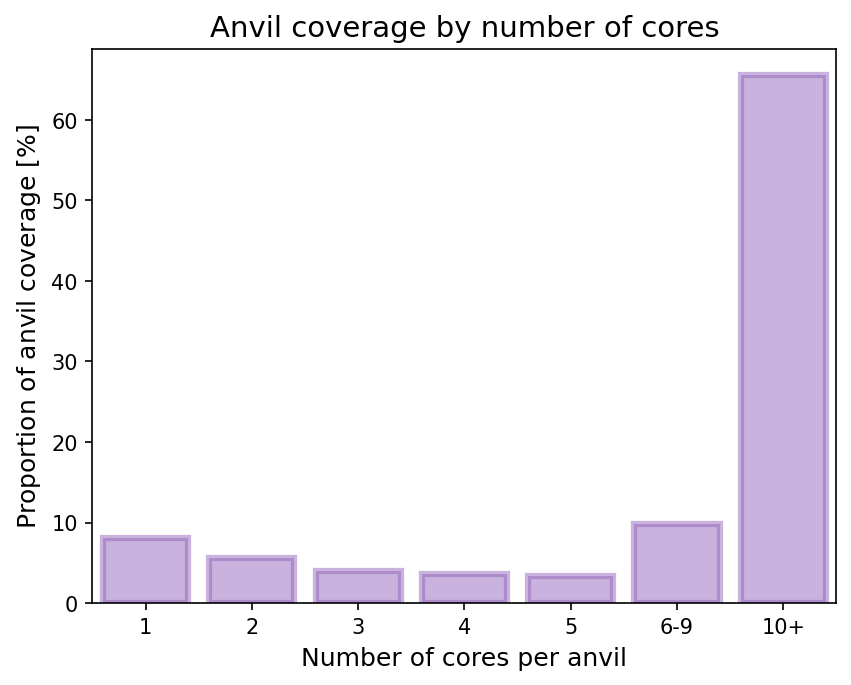

In [331]:
from scipy.stats import binned_statistic

anvil_total_area = np.concatenate([ds.thick_anvil_total_area.data for ds in datasets])

bar_data = binned_statistic(
    anvil_number_of_cores[anvil_is_valid], 
    anvil_total_area[anvil_is_valid], 
    bins=bins, 
    statistic="sum"
)

plt.figure(dpi=150)
plt.bar(bin_positions, bar_data[0]/np.sum(bar_data[0])*100, 
        alpha=0.5, facecolor = 'C4', edgecolor='C4', ls='solid', lw=3)

plt.xlim([0.5,7.5])
plt.xticks(bin_positions, bin_labels)
plt.xlabel("Number of cores per anvil", fontsize=12)
plt.ylabel("Proportion of anvil coverage [$\%$]", fontsize=12)
plt.title("Anvil coverage by number of cores", fontsize=14)

Text(0.5, 1.0, 'Average anvil CTT by number of cores')

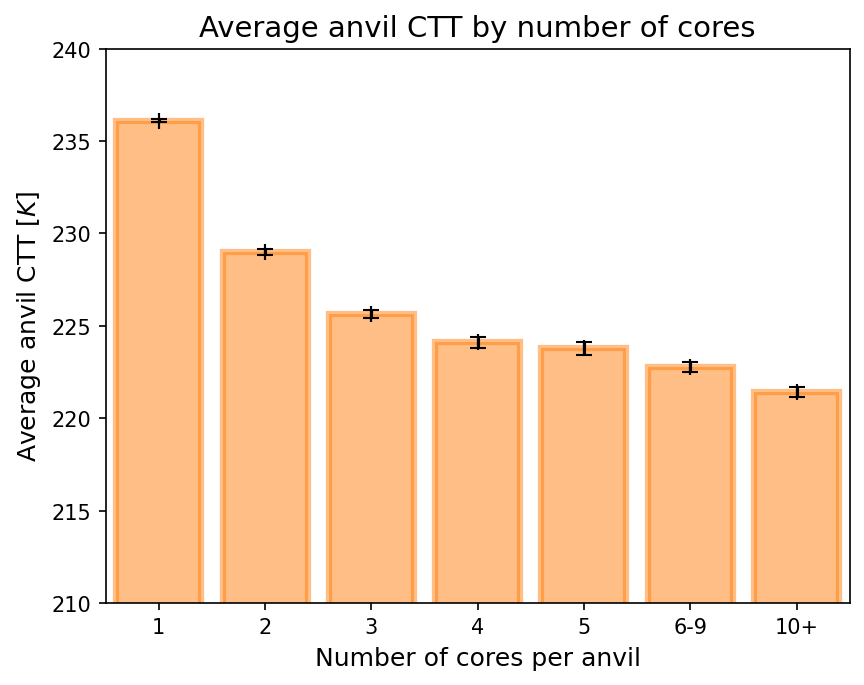

In [332]:
from scipy.stats import binned_statistic

ctt_mean = np.concatenate([ds.thick_anvil_ctt_mean.data for ds in datasets])

bar_data = binned_statistic(
    anvil_number_of_cores[anvil_is_valid], 
    ctt_mean[anvil_is_valid], 
    bins=bins, 
    statistic="mean"
)

errorbar_data = binned_statistic(
    anvil_number_of_cores[anvil_is_valid], 
    ctt_mean[anvil_is_valid], 
    bins=bins, 
    statistic="std"
)

counts = np.histogram(anvil_number_of_cores[anvil_is_valid], bins=bins)

errorbars = errorbar_data[0] / (counts[0])**0.5

plt.figure(dpi=150)
plt.bar(bin_positions, bar_data[0], 
        alpha=0.5, facecolor = 'C1', edgecolor='C1', ls='solid', lw=3)
plt.errorbar(bin_positions, bar_data[0], errorbars, 0, 
             color="k", linestyle="", capsize=4)

plt.xlim([0.5,7.5])
plt.ylim([210,240])
plt.xticks(bin_positions, bin_labels)
plt.xlabel("Number of cores per anvil", fontsize=12)
plt.ylabel("Average anvil CTT [$K$]", fontsize=12)
plt.title("Average anvil CTT by number of cores", fontsize=14)

Text(0.5, 1.0, 'Average anvil minimum CTT by number of cores')

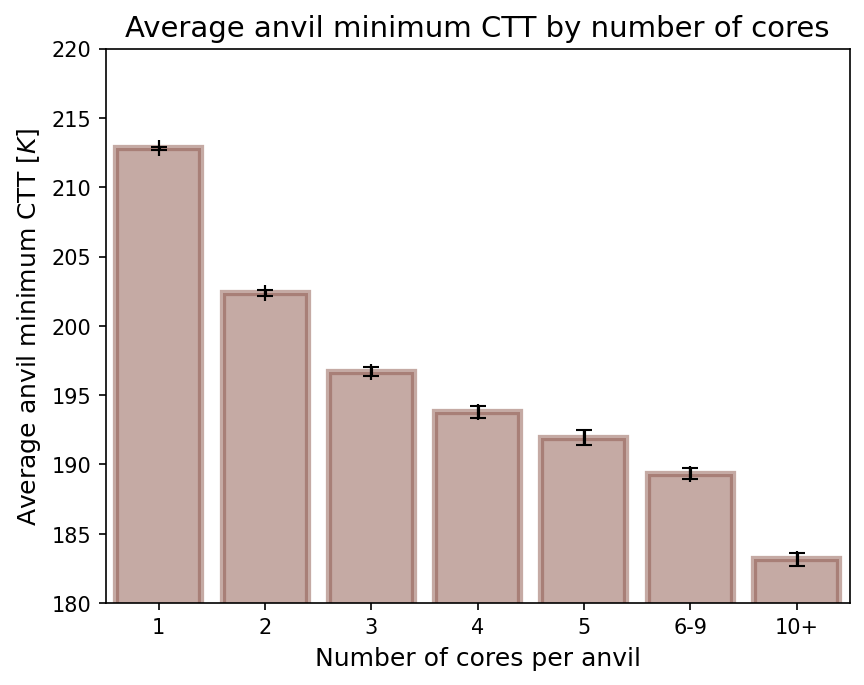

In [333]:
from scipy.stats import binned_statistic

ctt_min = np.concatenate([ds.thick_anvil_ctt_min.data for ds in datasets])

bar_data = binned_statistic(
    anvil_number_of_cores[anvil_is_valid], 
    ctt_min[anvil_is_valid], 
    bins=bins, 
    statistic="mean"
)

errorbar_data = binned_statistic(
    anvil_number_of_cores[anvil_is_valid], 
    ctt_min[anvil_is_valid], 
    bins=bins, 
    statistic="std"
)

counts = np.histogram(anvil_number_of_cores[anvil_is_valid], bins=bins)

errorbars = errorbar_data[0] / (counts[0])**0.5

plt.figure(dpi=150)
plt.bar(bin_positions, bar_data[0], 
        alpha=0.5, facecolor = 'C5', edgecolor='C5', ls='solid', lw=3)
plt.errorbar(bin_positions, bar_data[0], errorbars, 0, 
             color="k", linestyle="", capsize=4)

plt.xlim([0.5,7.5])
plt.ylim([180,220])
plt.xticks(bin_positions, bin_labels)
plt.xlabel("Number of cores per anvil", fontsize=12)
plt.ylabel("Average anvil minimum CTT [$K$]", fontsize=12)
plt.title("Average anvil minimum CTT by number of cores", fontsize=14)

Text(0.5, 1.0, 'Lifecycle of anvils by number of cores')

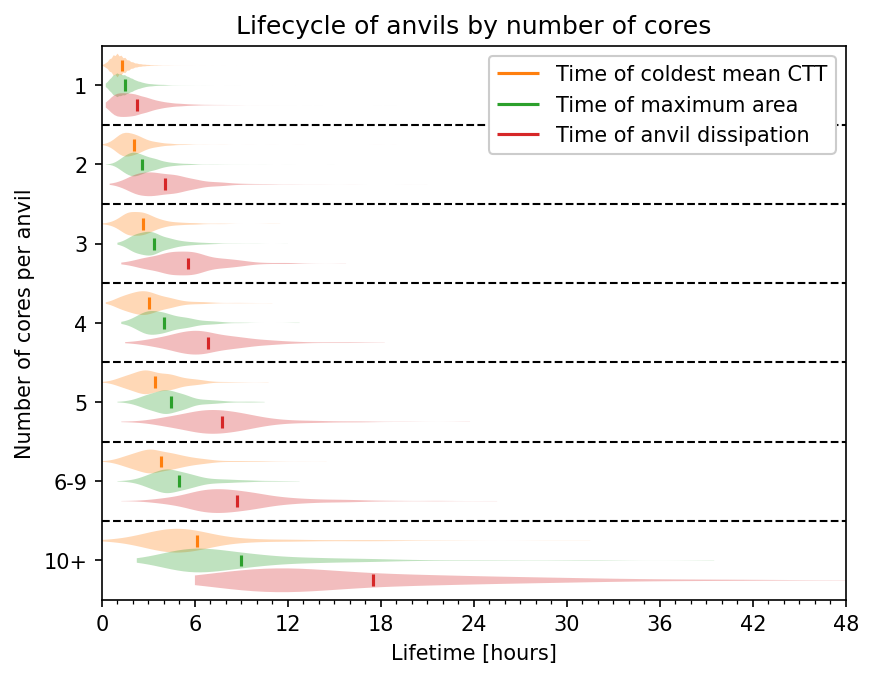

In [418]:
def anvil_initiation_t(ds):
    return np.minimum(
        ds.core_start_t.loc[ds.anvil_initial_core_index.data].data, 
        ds.thick_anvil_start_t.data
    )

anvil_time_to_min_BT = np.concatenate([ds.thick_anvil_min_ctt_t.data - anvil_initiation_t(ds) for ds in datasets]).astype("timedelta64[s]").astype(int)/3600
anvil_time_to_max_thick_area = np.concatenate([ds.thick_anvil_max_area_t.data - anvil_initiation_t(ds) for ds in datasets]).astype("timedelta64[s]").astype(int)/3600
thick_anvil_lifetime = np.concatenate([ds.thick_anvil_end_t.data - anvil_initiation_t(ds)for ds in datasets]).astype("timedelta64[s]").astype(int)/3600
thin_anvil_lifetime = np.concatenate([ds.thin_anvil_end_t.data - anvil_initiation_t(ds) for ds in datasets]).astype("timedelta64[s]").astype(int)/3600

fig = plt.figure(dpi=150)
ax = plt.subplot(111)

for i in range(1,8):
    if i==6:
        wh = np.logical_and(anvil_number_of_cores>=5, anvil_number_of_cores<=9)
    elif i==7:
        wh = anvil_number_of_cores>=10
    else:
        wh = anvil_number_of_cores==i
        
    wh = np.logical_and(wh, anvil_is_valid)
    
#     vp1 = plt.violinplot(anvil_growth_period_array[wh], 
#                    positions=[i-0.3], widths=0.3, showextrema=False, showmeans=True, vert=False)
#     for pc in vp1['bodies']:
#         pc.set_facecolor("C0")
#     vp1['cmeans'].set_edgecolor("C0")
    
    vp2 = plt.violinplot(anvil_time_to_min_BT[wh], 
                   positions=[i-0.25], widths=0.3, showextrema=False, showmeans=True, vert=False)
    for pc in vp2['bodies']:
        pc.set_facecolor("C1")
    vp2['cmeans'].set_edgecolor("C1")
    
    if i!=0:
        vp3 = plt.violinplot(anvil_time_to_max_thick_area[wh], 
                       positions=[i], widths=0.3, showextrema=False, showmeans=True, vert=False)
        for pc in vp3['bodies']:
            pc.set_facecolor("C2")
        vp3['cmeans'].set_edgecolor("C2")
    
    vp4 = plt.violinplot(thick_anvil_lifetime[wh], 
                   positions=[i+0.25], widths=0.3, showextrema=False, showmeans=True, vert=False)
    for pc in vp4['bodies']:
        pc.set_facecolor("C3")
    vp4['cmeans'].set_edgecolor("C3")
    
#     vp5 = plt.violinplot(thin_anvil_lifetime[wh], 
#                    positions=[i+0.3], widths=0.3, showextrema=False, showmeans=True, vert=False)
#     for pc in vp5['bodies']:
#         pc.set_facecolor("C4")
#     vp5['cmeans'].set_edgecolor("C4")
    

# plt.legend([vp1['cmeans'], vp2['cmeans'], vp3['cmeans'], vp4['cmeans'], vp5['cmeans']], 
#            ["Mean core lifetime", "Time of coldest BT", "Time of maximum area", 
#             "Time of thick anvil dissipation", "Time of thin anvil dissipation"])

for i in range(1,7):
    ax.axhline(y=i+0.5, color='k', linestyle="--", linewidth=1)
    
plt.legend(
    [vp2['cmeans'], vp3['cmeans'], vp4['cmeans']], 
    ["Time of coldest mean CTT", "Time of maximum area", "Time of anvil dissipation"], 
    fontsize=10, framealpha=1
)

plt.gca().invert_yaxis()
plt.xlim(0,48)
plt.ylim([7.5,0.5])
plt.xticks(range(0,49,6), range(0,49,6))
ax.minorticks_on()
plt.xticks(range(0,49,1), [""]*49, minor=True)
ax.yaxis.set_tick_params(which='minor', left=False)

plt.yticks(range(1,8), [1,2,3,4,5,"6-9","10+"])#["No anvil",1,2,3,4,"5-9","10+"])

plt.xlabel("Lifetime [hours]")
plt.ylabel("Number of cores per anvil")
plt.title("Lifecycle of anvils by number of cores")

In [414]:
ax.xaxis.minor?

Text(0.5, 1.0, 'Lifecycle of anvils by number of cores')

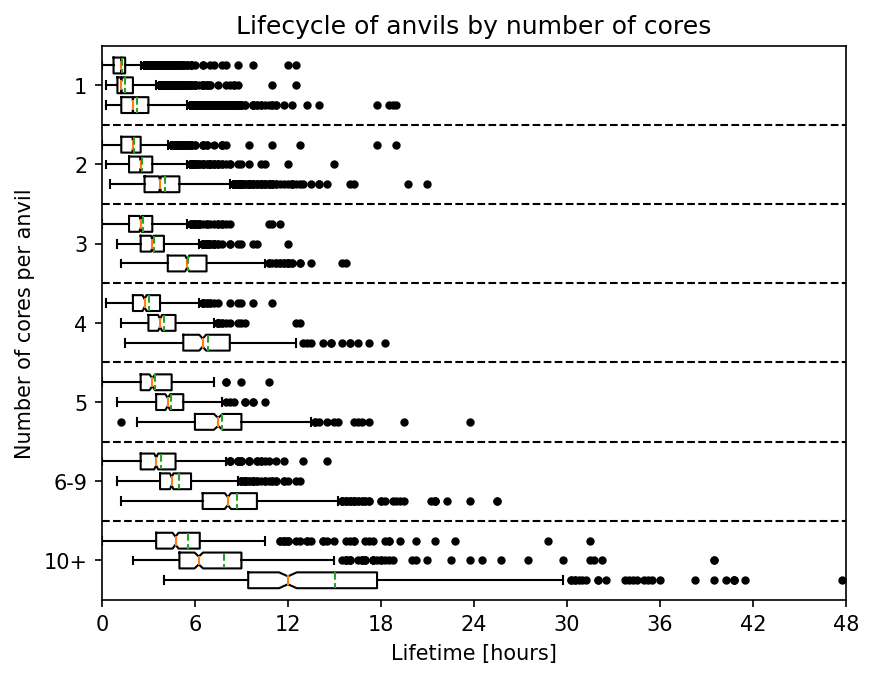

In [409]:
def anvil_initiation_t(ds):
    return np.minimum(
        ds.core_start_t.loc[ds.anvil_initial_core_index.data].data, 
        ds.thick_anvil_start_t.data
    )

anvil_time_to_min_BT = np.concatenate([ds.thick_anvil_min_ctt_t.data - anvil_initiation_t(ds) for ds in datasets]).astype("timedelta64[s]").astype(int)/3600
anvil_time_to_max_thick_area = np.concatenate([ds.thick_anvil_max_area_t.data - anvil_initiation_t(ds) for ds in datasets]).astype("timedelta64[s]").astype(int)/3600
thick_anvil_lifetime = np.concatenate([ds.thick_anvil_end_t.data - anvil_initiation_t(ds)for ds in datasets]).astype("timedelta64[s]").astype(int)/3600
thin_anvil_lifetime = np.concatenate([ds.thin_anvil_end_t.data - anvil_initiation_t(ds) for ds in datasets]).astype("timedelta64[s]").astype(int)/3600

fig = plt.figure(dpi=150)
ax = plt.subplot(111)

for i in range(1,8):
    if i==6:
        wh = np.logical_and(anvil_number_of_cores>=5, anvil_number_of_cores<=9)
    elif i==7:
        wh = anvil_number_of_cores>i
    else:
        wh = anvil_number_of_cores==i
        
    wh = np.logical_and(wh, anvil_is_valid)
    
#     vp1 = plt.violinplot(anvil_growth_period_array[wh], 
#                    positions=[i-0.3], widths=0.3, showextrema=False, showmeans=True, vert=False)
#     for pc in vp1['bodies']:
#         pc.set_facecolor("C0")
#     vp1['cmeans'].set_edgecolor("C0")
    
    vp2 = plt.boxplot(anvil_time_to_min_BT[wh], 
                   positions=[i-0.25], widths=0.2, showmeans=True, meanline=True, vert=False, notch=True, sym="k.")
#     for pc in vp2['bodies']:
#         pc.set_facecolor("C1")
#     vp2['cmeans'].set_edgecolor("C1")
    
    if i!=0:
        vp3 = plt.boxplot(anvil_time_to_max_thick_area[wh], 
                       positions=[i], widths=0.2, showmeans=True, meanline=True, vert=False, notch=True, sym="k.")
#         for pc in vp3['bodies']:
#             pc.set_facecolor("C2")
#         vp3['cmeans'].set_edgecolor("C2")
    
    vp4 = plt.boxplot(thick_anvil_lifetime[wh], 
                   positions=[i+0.25], widths=0.2, showmeans=True, meanline=True, vert=False, notch=True, sym="k.")
#     for pc in vp4['bodies']:
#         pc.set_facecolor("C3")
#     vp4['cmeans'].set_edgecolor("C3")
    
#     vp5 = plt.violinplot(thin_anvil_lifetime[wh], 
#                    positions=[i+0.3], widths=0.3, showextrema=False, showmeans=True, vert=False)
#     for pc in vp5['bodies']:
#         pc.set_facecolor("C4")
#     vp5['cmeans'].set_edgecolor("C4")
    

# plt.legend([vp1['cmeans'], vp2['cmeans'], vp3['cmeans'], vp4['cmeans'], vp5['cmeans']], 
#            ["Mean core lifetime", "Time of coldest BT", "Time of maximum area", 
#             "Time of thick anvil dissipation", "Time of thin anvil dissipation"])

for i in range(1,7):
    ax.axhline(y=i+0.5, color='k', linestyle="--", linewidth=1)
    
# plt.legend(
#     [vp2['cmeans'], vp3['cmeans'], vp4['cmeans']], 
#     ["Time of coldest mean CTT", "Time of maximum area", "Time of anvil dissipation"], 
#     fontsize=10, framealpha=1
# )

plt.gca().invert_yaxis()
plt.xlim(0,48)
plt.ylim([7.5,0.5])
plt.xticks(range(0,49,6) ,range(0,49,6))
plt.yticks(range(1,8), [1,2,3,4,5,"6-9","10+"])#["No anvil",1,2,3,4,"5-9","10+"])

plt.xlabel("Lifetime [hours]")
plt.ylabel("Number of cores per anvil")
plt.title("Lifecycle of anvils by number of cores")

In [393]:
plt.legend?

In [334]:
[(ds.thick_anvil_lifetime[ds.thick_anvil_is_valid.data].max().item()/1e9/3600, ds.thick_anvil_lifetime[ds.thick_anvil_is_valid.data].idxmax().item()) for ds in datasets]

[(80.5, 16854), (58.75, 22308), (51.0, 174), (57.25, 15675)]

In [335]:
[(ds.thick_anvil_lifetime.max().item()/1e9/3600, ds.thick_anvil_lifetime.idxmax().item()) for ds in datasets]

[(118.0, 23063), (87.25, 18057), (96.25, 16125), (88.5, 25081)]

In [99]:
[(ds.thick_anvil_lifetime[np.logical_and(ds.thick_anvil_is_valid.data, ds.anvil_core_count.data==1)].median().item()/1e9/3600, 
  ds.thick_anvil_lifetime[np.logical_and(ds.thick_anvil_is_valid.data, ds.anvil_core_count.data==1)].anvil.median().item()) 
 for ds in datasets]

[(2.0, 18030.0), (1.75, 14886.0), (1.75, 14838.0), (1.75, 16710.0)]

In [100]:
datasets[2].anvil[np.logical_and.reduce([
    datasets[2].thick_anvil_is_valid.data, 
    datasets[2].anvil_core_count.data==1, 
    datasets[2].thick_anvil_lifetime.data>=np.timedelta64(4, "h")
])][310:330]

<xarray.DataArray 'anvil' (anvil: 20)>
array([13494, 13616, 13707, 13858, 13888, 13981, 14014, 14055, 14115, 14154,
       14171, 14173, 14192, 14277, 14324, 14395, 14397, 14406, 14463, 14485])
Coordinates:
  * anvil    (anvil) int64 13494 13616 13707 13858 ... 14397 14406 14463 14485

Text(0.5, 1.0, 'Cloud radiative effect over DCC lifetime')

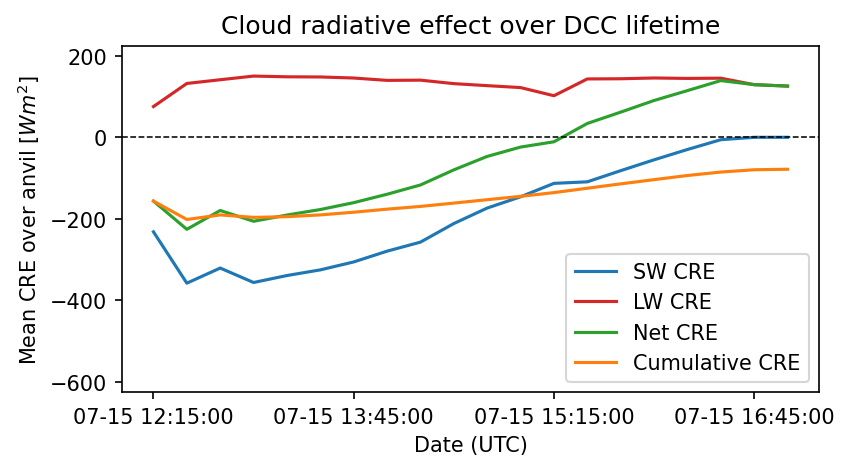

In [101]:
dataset = datasets[2]
anvil = 14680
# core = np.where(wh_core_step = dataset.core_step_core_index.data==core)+1
# wh_core_step = dataset.core_step_core_index.data==core
wh_thick_anvil_step = dataset.thick_anvil_step_anvil_index.data==anvil
wh_thin_anvil_step = dataset.thin_anvil_step_anvil_index.data==anvil


plt.figure(dpi=150, figsize=(6,3))

ax = plt.subplot(111)

plt.plot(-dataset.thick_anvil_step_toa_swup_cre_mean[dataset.thick_anvil_step_anvil_index==anvil], "C0")
plt.plot(-dataset.thick_anvil_step_toa_lwup_cre_mean[dataset.thick_anvil_step_anvil_index==anvil], "C3")
plt.plot(dataset.thick_anvil_step_toa_cre_mean[dataset.thick_anvil_step_anvil_index==anvil], "C2")

cumulative_forcing = np.cumsum(dataset.thick_anvil_step_toa_cre_mean[dataset.thick_anvil_step_anvil_index==anvil] * dataset.thick_anvil_step_area[dataset.thick_anvil_step_anvil_index==anvil])
cumulative_forcing /= np.cumsum(dataset.thick_anvil_step_area[dataset.thick_anvil_step_anvil_index==anvil])
plt.plot(cumulative_forcing, "C1")

plt.legend(["SW CRE", "LW CRE", "Net CRE", "Cumulative CRE"])

plt.ylabel("Mean CRE over anvil [$Wm^2$]")
plt.xlabel("Date (UTC)")

ax.axhline(y=0, color='k', linestyle="--", linewidth=0.75)

core_dt = dataset.thick_anvil_step_t[dataset.thick_anvil_step_anvil_index==anvil].to_series().dt.to_pydatetime()
core_time_str = [str(dt)[-14:] for dt in core_dt]
n_time_steps = len(core_time_str)

plt.ylim([-625,225])
plt.xticks(range(0, n_time_steps, int(np.floor(n_time_steps/3))), core_time_str[::int(np.floor(n_time_steps/3))])

plt.title('Cloud radiative effect over DCC lifetime')

In [102]:
datasets[3].anvil[datasets[3].thick_anvil_is_valid.data].sortby(datasets[3].thick_anvil_lifetime[datasets[3].thick_anvil_is_valid.data])[-10:]

<xarray.DataArray 'anvil' (anvil: 10)>
array([10748,  7846, 27739, 10125, 22613, 18527, 29216, 14725, 29028, 15675])
Coordinates:
  * anvil    (anvil) int64 10748 7846 27739 10125 ... 29216 14725 29028 15675

Text(0.5, 1.0, 'Cloud radiative effect over DCC lifetime')

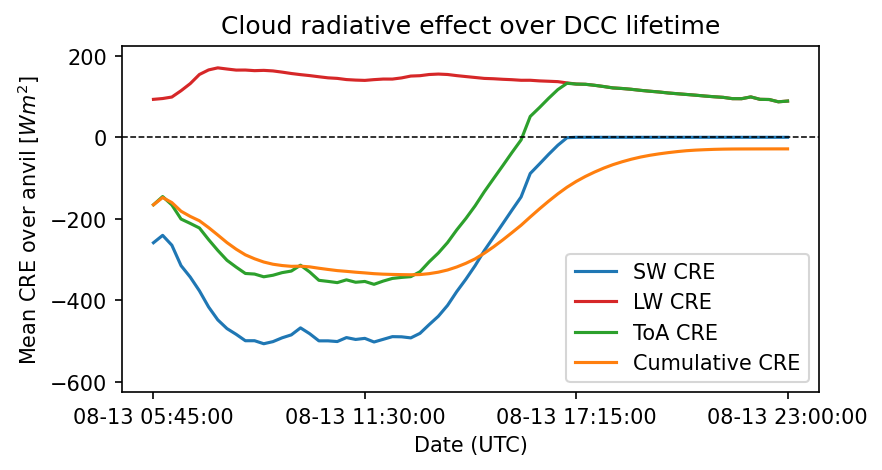

In [103]:
dataset = datasets[3]
anvil = 9871
# core = np.where(dataset.core_anvil_index.data==anvil)+1
# wh_core_step = dataset.core_step_core_index.data==core
wh_thick_anvil_step = dataset.thick_anvil_step_anvil_index.data==anvil
wh_thin_anvil_step = dataset.thin_anvil_step_anvil_index.data==anvil


plt.figure(dpi=150, figsize=(6,3))

ax = plt.subplot(111)

plt.plot(-dataset.thick_anvil_step_toa_swup_cre_mean[dataset.thick_anvil_step_anvil_index==anvil], "C0")
plt.plot(-dataset.thick_anvil_step_toa_lwup_cre_mean[dataset.thick_anvil_step_anvil_index==anvil], "C3")
plt.plot(dataset.thick_anvil_step_toa_cre_mean[dataset.thick_anvil_step_anvil_index==anvil], "C2")

cumulative_forcing = np.cumsum(dataset.thick_anvil_step_toa_cre_mean[dataset.thick_anvil_step_anvil_index==anvil] * dataset.thick_anvil_step_area[dataset.thick_anvil_step_anvil_index==anvil])
cumulative_forcing /= np.cumsum(dataset.thick_anvil_step_area[dataset.thick_anvil_step_anvil_index==anvil])
plt.plot(cumulative_forcing, "C1")

plt.legend(["SW CRE", "LW CRE", "ToA CRE", "Cumulative CRE"])

plt.ylabel("Mean CRE over anvil [$Wm^2$]")
plt.xlabel("Date (UTC)")

ax.axhline(y=0, color='k', linestyle="--", linewidth=0.75)

core_dt = dataset.thick_anvil_step_t[dataset.thick_anvil_step_anvil_index==anvil].to_series().dt.to_pydatetime()
core_time_str = [str(dt)[-14:] for dt in core_dt]
n_time_steps = len(core_time_str)

plt.ylim([-625,225])
plt.xticks(range(0, n_time_steps, int(np.floor(n_time_steps/3))), core_time_str[::int(np.floor(n_time_steps/3))])

plt.title('Cloud radiative effect over DCC lifetime')

Text(0.5, 1.0, 'Cloud radiative effect over DCC lifetime')

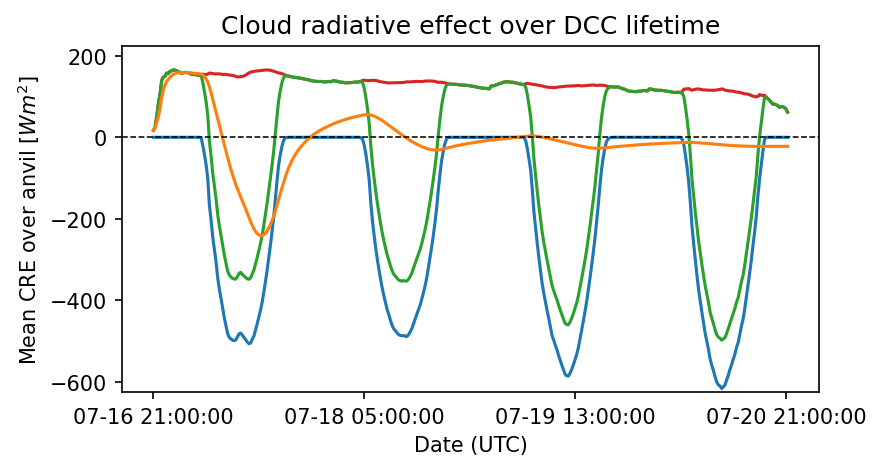

In [104]:
dataset = datasets[2]
anvil = 16125
# core = np.where(dataset.core_anvil_index.data==anvil)+1
# wh_core_step = dataset.core_step_core_index.data==core
wh_thick_anvil_step = dataset.thick_anvil_step_anvil_index.data==anvil
wh_thin_anvil_step = dataset.thin_anvil_step_anvil_index.data==anvil


plt.figure(dpi=150, figsize=(6,3))

ax = plt.subplot(111)

plt.plot(-dataset.thick_anvil_step_toa_swup_cre_mean[dataset.thick_anvil_step_anvil_index==anvil], "C0")
plt.plot(-dataset.thick_anvil_step_toa_lwup_cre_mean[dataset.thick_anvil_step_anvil_index==anvil], "C3")
plt.plot(dataset.thick_anvil_step_toa_cre_mean[dataset.thick_anvil_step_anvil_index==anvil], "C2")

cumulative_forcing = np.cumsum(dataset.thick_anvil_step_toa_cre_mean[dataset.thick_anvil_step_anvil_index==anvil] * dataset.thick_anvil_step_area[dataset.thick_anvil_step_anvil_index==anvil])
cumulative_forcing /= np.cumsum(dataset.thick_anvil_step_area[dataset.thick_anvil_step_anvil_index==anvil])
plt.plot(cumulative_forcing, "C1")

# plt.legend(["SW CRE", "LW CRE", "Net CRE", "Cumulative CRE"])

plt.ylabel("Mean CRE over anvil [$Wm^2$]")
plt.xlabel("Date (UTC)")

ax.axhline(y=0, color='k', linestyle="--", linewidth=0.75)

core_dt = dataset.thick_anvil_step_t[dataset.thick_anvil_step_anvil_index==anvil].to_series().dt.to_pydatetime()
core_time_str = [str(dt)[-14:] for dt in core_dt]
n_time_steps = len(core_time_str)

plt.ylim([-625,225])
plt.xticks(range(0, n_time_steps, int(np.floor(n_time_steps/3))), core_time_str[::int(np.floor(n_time_steps/3))])

plt.title('Cloud radiative effect over DCC lifetime')

Text(0.5, 1.0, 'DCC Mean ToA CRE distribution [Mean: -1.86 $Wm^{-2}$]')

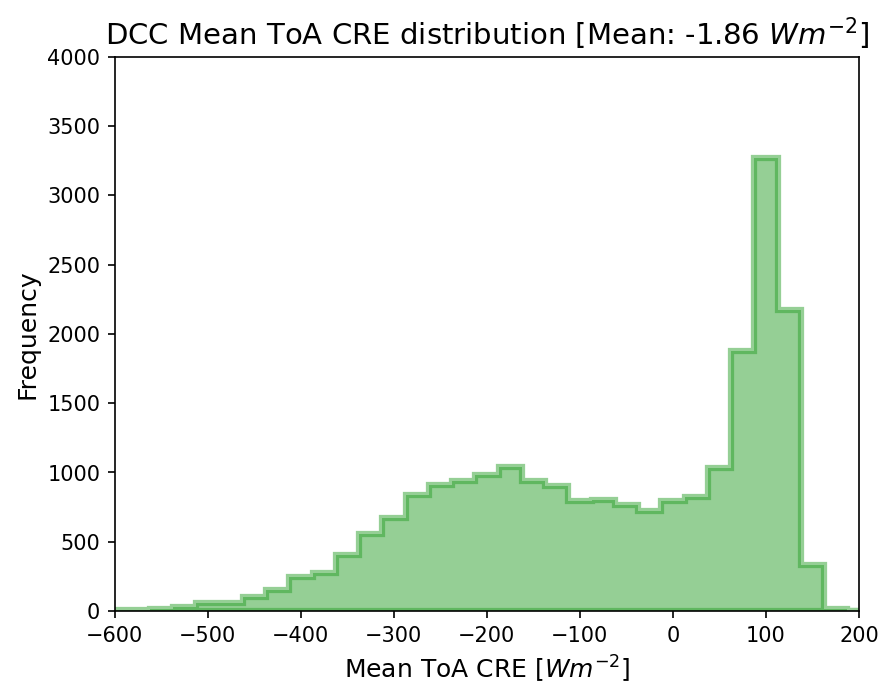

In [337]:
net_cre = np.concatenate([ds.thick_anvil_toa_cre_mean.data for ds in datasets])

plt.figure(dpi=150)
plt.hist(net_cre[anvil_is_valid], bins=np.arange(-600,226,25)-12.5,  
         alpha=0.5, facecolor = 'C2', edgecolor='C2', ls='solid', lw=3, histtype='stepfilled')
plt.xlim([-600,200])
plt.xlabel("Mean ToA CRE [$Wm^{-2}$]", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.ylim([0,4000])
mean_cre = np.average(net_cre[anvil_is_valid], weights=anvil_total_area[anvil_is_valid])
plt.title("DCC Mean ToA CRE distribution [Mean: %s $Wm^{-2}$]" % str(np.round(mean_cre, 2)), fontsize=14)

Text(0.5, 1.0, 'DCC Mean ToA CRE distribution [Mean: -1.86 $Wm^{-2}$]')

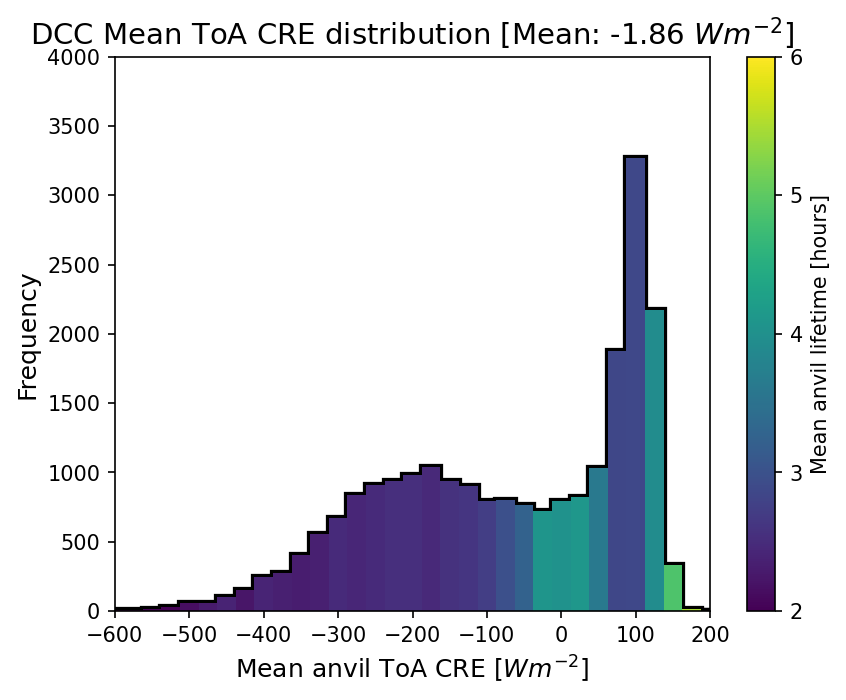

In [363]:
plt.figure(dpi=150)

plt.hist(net_cre[anvil_is_valid], bins=np.arange(-600,226,25)-12.5,  
         alpha=1, facecolor = 'none', edgecolor='black', ls='solid', lw=3, histtype='stepfilled')

bar_data = np.histogram(net_cre[anvil_is_valid], bins=np.arange(-600,226,25)-12.5)[0]
bar_color = binned_statistic(
    net_cre[anvil_is_valid], 
    anvil_lifetime[anvil_is_valid], 
    bins=np.arange(-600,226,25)-12.5, 
    statistic="mean"
)[0]

bar = plt.bar(
    np.arange(-600,225,25), bar_data, width=25,  
    alpha=1, color = plt.cm.viridis((bar_color-2)/4), edgecolor='none'
)

img = plt.imshow(np.array([[2,6]]), aspect="auto")
img.set_visible(False)

cbar = plt.colorbar(orientation="vertical")
cbar.set_label("Mean anvil lifetime [hours]")
cbar.set_ticks([2,3,4,5,6])


plt.xlim([-600,200])
plt.xlabel("Mean anvil ToA CRE [$Wm^{-2}$]", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.ylim([0,4000])
mean_cre = np.average(net_cre[anvil_is_valid], weights=anvil_total_area[anvil_is_valid])
plt.title("DCC Mean ToA CRE distribution [Mean: %s $Wm^{-2}$]" % str(np.round(mean_cre, 2)), fontsize=14)

In [364]:
boa_cre = np.concatenate([ds.thick_anvil_boa_cre_mean.data for ds in datasets])

plt.figure(dpi=150)

plt.hist(net_cre[anvil_is_valid], bins=np.arange(-600,226,25)-12.5,  
         alpha=1, facecolor = 'none', edgecolor='black', ls='solid', lw=3, histtype='stepfilled')

bar_data = np.histogram(boa_cre[anvil_is_valid], bins=np.arange(-600,226,25)-12.5)[0]
bar_color = binned_statistic(
    net_cre[anvil_is_valid], 
    anvil_lifetime[anvil_is_valid], 
    bins=np.arange(-600,226,25)-12.5, 
    statistic="mean"
)[0]

bar = plt.bar(
    np.arange(-600,225,25), bar_data, width=25,  
    alpha=1, color = plt.cm.viridis((bar_color-2)/4), edgecolor='none'
)

img = plt.imshow(np.array([[2,6]]), aspect="auto")
img.set_visible(False)

cbar = plt.colorbar(orientation="vertical")
cbar.set_label("Mean anvil lifetime [hours]")
cbar.set_ticks([2,3,4,5,6])


plt.xlim([-600,200])
plt.xlabel("Mean anvil ToA CRE [$Wm^{-2}$]", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.ylim([0,4000])
mean_cre = np.average(boa_cre[anvil_is_valid], weights=anvil_total_area[anvil_is_valid])
plt.title("DCC Mean ToA CRE distribution [Mean: %s $Wm^{-2}$]" % str(np.round(mean_cre, 2)), fontsize=14)

AttributeError: 'Dataset' object has no attribute 'thick_anvil_boa_cre_mean'

Text(0.5, 1.0, 'Mean CRE distribution [Average: -1.86±1.10 $Wm^{-2}$]')

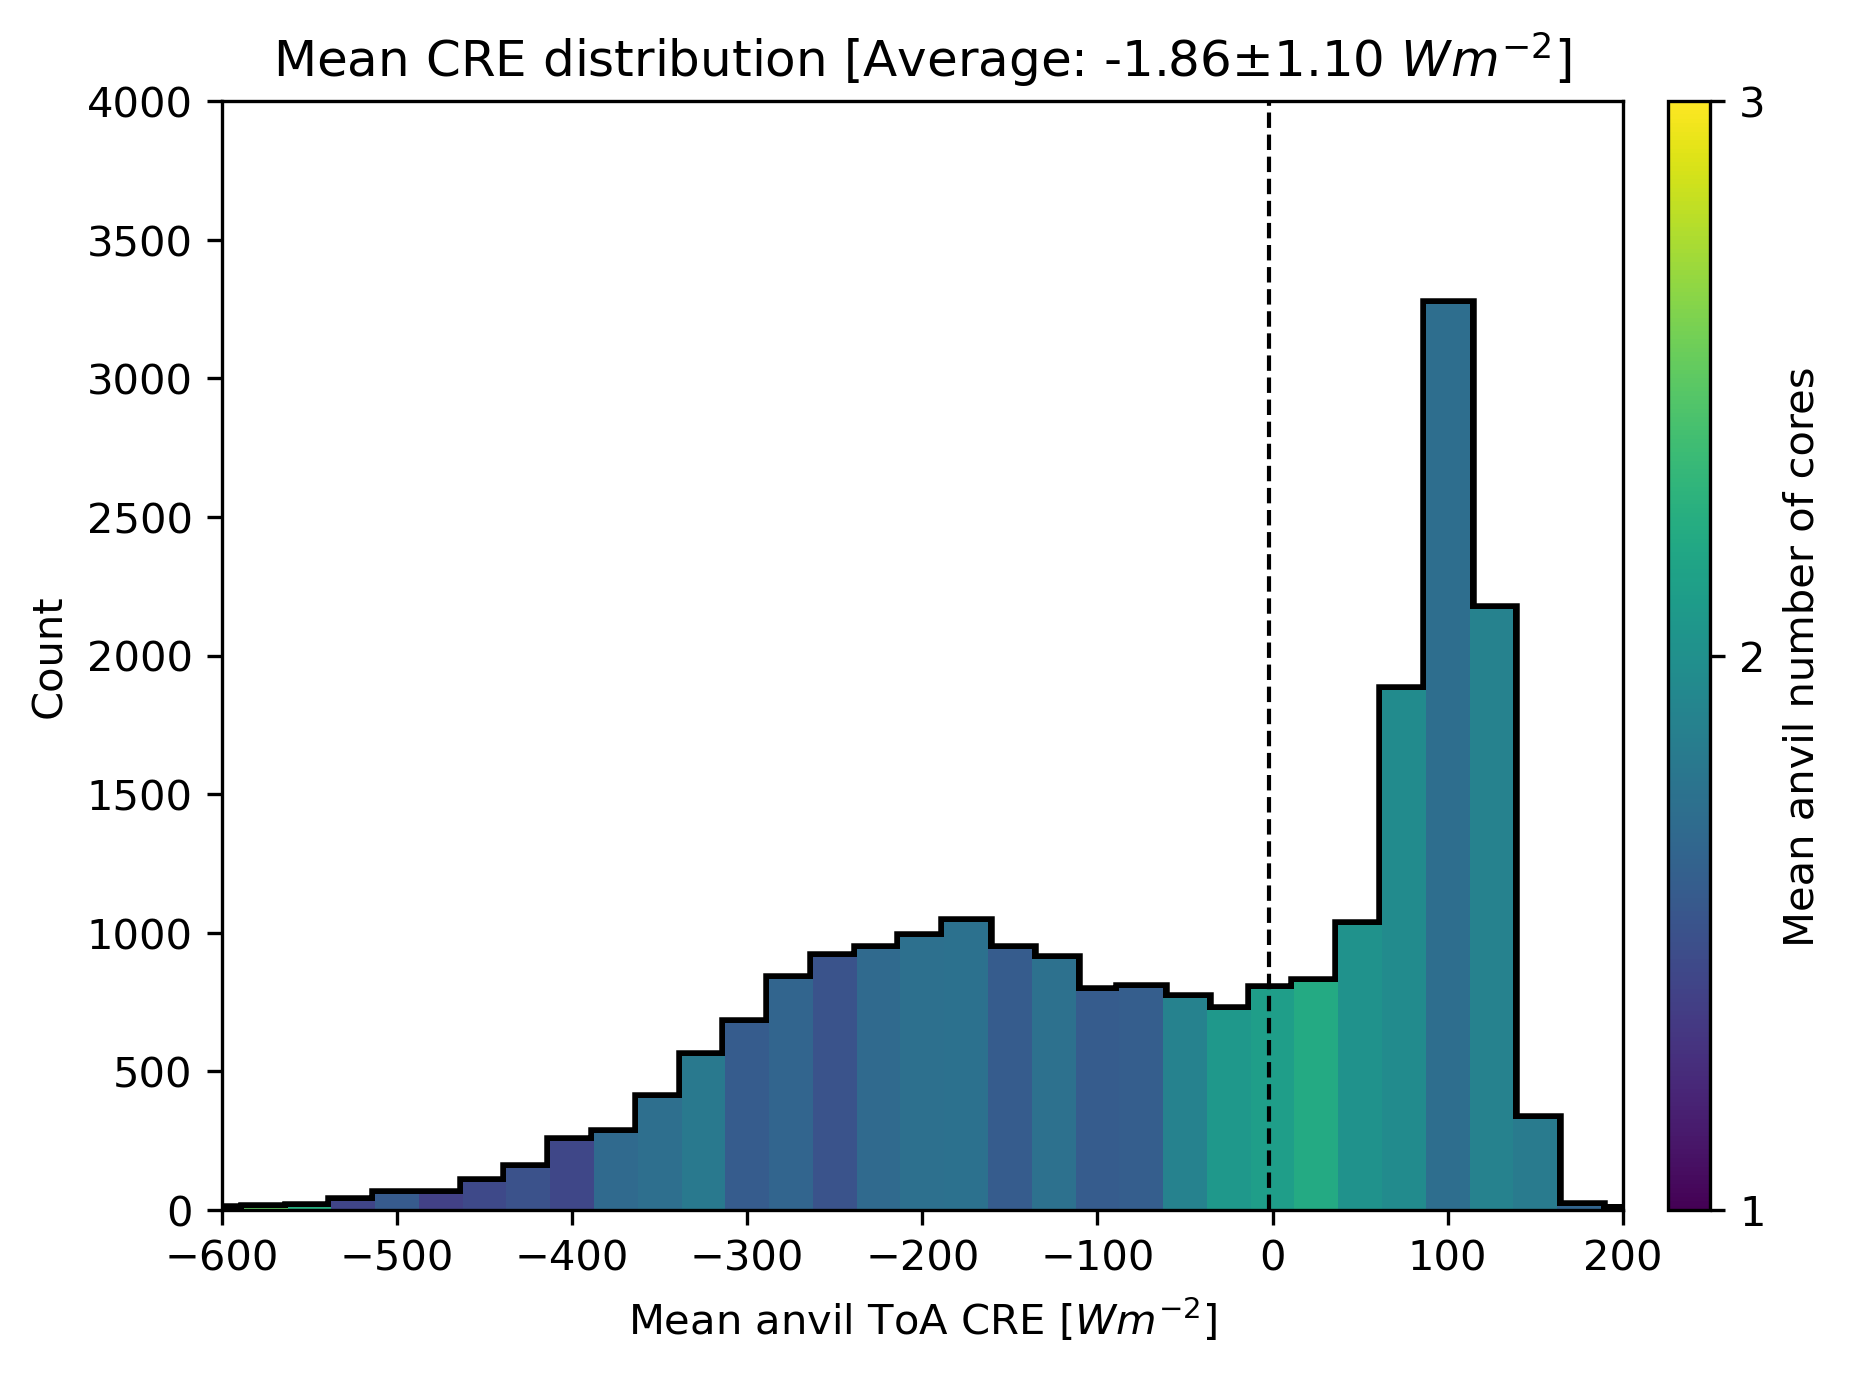

In [361]:
net_cre = np.concatenate([ds.thick_anvil_toa_cre_mean.data for ds in datasets])

fig = plt.figure(dpi=300)
ax = plt.subplot(111)

plt.hist(net_cre[anvil_is_valid], bins=np.arange(-600,226,25)-12.5,  
         alpha=1, facecolor = 'none', edgecolor='black', ls='solid', lw=3, histtype='stepfilled')

bar_data = np.histogram(net_cre[anvil_is_valid], bins=np.arange(-600,226,25)-12.5)[0]
bar_color = binned_statistic(
    net_cre[anvil_is_valid], 
    warm_anvil_core_count[anvil_is_valid], 
    bins=np.arange(-600,226,25)-12.5, 
    statistic="mean"
)[0]

bar = plt.bar(
    np.arange(-600,225,25), bar_data, width=25,  
    alpha=1, color = plt.cm.viridis((bar_color-1)/2), edgecolor='none'
)

plt.xlim([-600,200])
plt.xlabel("Mean anvil ToA CRE [$Wm^{-2}$]", fontsize=10)
plt.ylabel("Count", fontsize=10)
plt.ylim([0,4000])


cbar_size="3%"
cbar_pad=0.15

img = plt.imshow(np.array([[1,3]]), aspect="auto")
img.set_visible(False)
ax_divider = make_axes_locatable(ax)
cax_r = ax_divider.new_horizontal(size=cbar_size, pad=cbar_pad, axes_class=plt.Axes)
fig.add_axes(cax_r)
cbar = plt.colorbar(img, cax=cax_r, label="Mean anvil number of cores")
cbar.set_ticks([1,2,3])

mean_cre = np.average(net_cre[anvil_is_valid], weights=anvil_total_area[anvil_is_valid])
mean_error = np.std(net_cre[anvil_is_valid])*np.sum(anvil_is_valid)**0.5/(np.sum(anvil_is_valid)-1)
ax.axvline(x=mean_cre, color='k', linestyle="--", linewidth=1)

# ax.set_title("(a)", loc="left", ha="right", weight="bold")
dp = 2
unit = "Wm^{-2}"
ax.set_title(f"Mean CRE distribution [Average: %.{dp}f±%.{dp}f ${unit}$]" % (np.round(mean_cre, dp), np.round(mean_error, dp)))

In [107]:
def weighted_avg_and_std(values, weights):
    """
    Return the weighted average and standard deviation.

    values, weights -- NumPy ndarrays with the same shape.
    """
    average = np.average(values, weights=weights)
    # Fast and numerically precise:
    variance = np.average((values-average)**2, weights=weights)
    return average, variance**0.5

In [108]:
mean, std = weighted_avg_and_std(net_cre[anvil_is_valid], anvil_total_area[anvil_is_valid])

In [193]:
gaussian = lambda x, mean, std : 1 / (std * (2*np.pi)**0.5) * np.exp(-0.5 * ((x - mean)/std)**2)

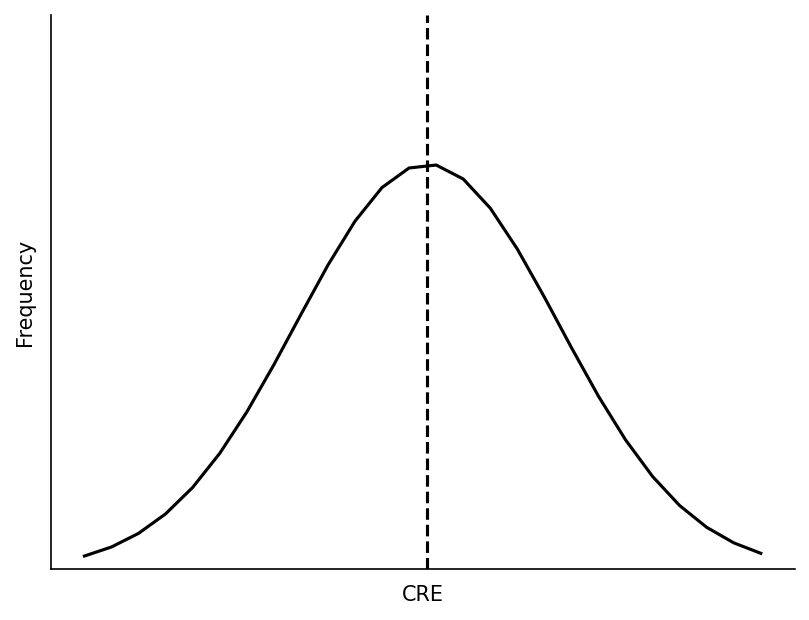

In [194]:
fig = plt.figure(dpi=150)
ax = plt.subplot(111)
plt.plot(np.arange(-325,325,25), gaussian(np.arange(-325,325,25), mean, std), "k")
plt.plot([mean,mean], [0, 0.0045], "k--")
plt.ylim([0,0.0045])
plt.xticks([])
plt.yticks([])
plt.xlabel("CRE")
plt.ylabel("Frequency")
ax.spines[['right', 'top']].set_visible(False)


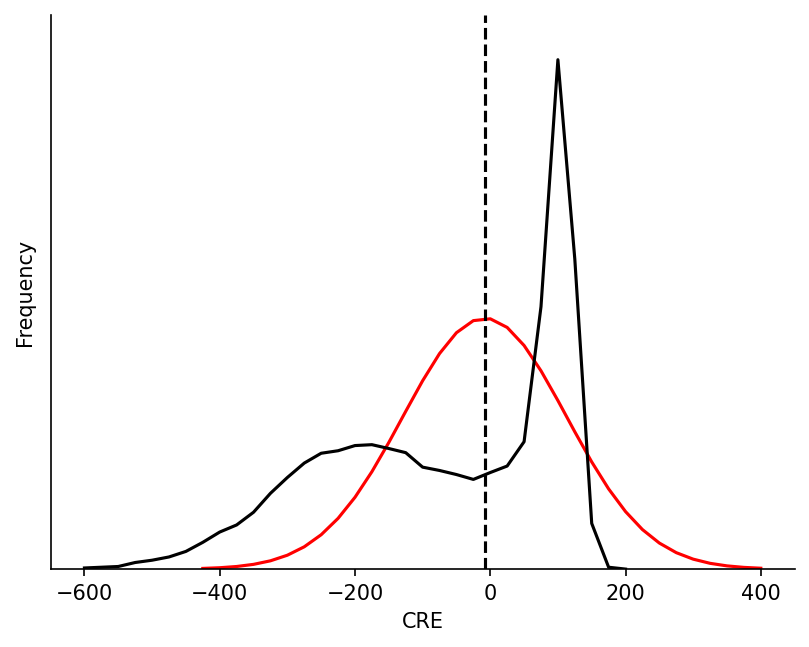

In [195]:
fig = plt.figure(dpi=150)
ax = plt.subplot(111)
plt.plot(
    np.arange(-425,425,25), 
    gaussian(np.arange(-425,425,25), mean, std)*np.sum(anvil_is_valid)*25, 
    "r"
)

plt.plot(
    np.arange(-600,225,25), 
    np.histogram(net_cre[anvil_is_valid], bins=np.arange(-600,226,25)-12.5)[0], 
    "k"
)

plt.plot([mean,mean], [0, 7500], "k--")
plt.ylim([0,7500])
# plt.xticks([])
plt.yticks([])
plt.xlabel("CRE")
plt.ylabel("Frequency")
ax.spines[['right', 'top']].set_visible(False)


In [185]:
mean_lw, std_lw = weighted_avg_and_std(lw_cre[anvil_is_valid], anvil_total_area[anvil_is_valid])

In [202]:
std_lw

15.25078693298137

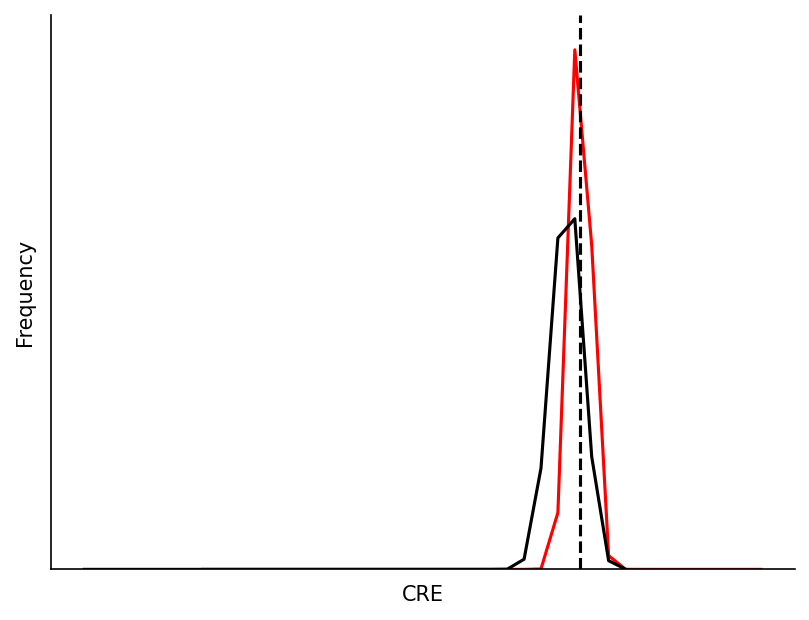

In [201]:
fig = plt.figure(dpi=150)
ax = plt.subplot(111)
plt.plot(
    np.arange(-425,425,25), 
    gaussian(np.arange(-425,425,25), mean_lw, std_lw)*np.sum(anvil_is_valid)*25, 
    "r"
)

plt.plot(
    np.arange(-600,225,25), 
    np.histogram(lw_cre[anvil_is_valid], bins=np.arange(-600,226,25)-12.5)[0], 
    "k"
)

plt.plot([mean_lw, mean_lw], [0, 25000], "k--")
plt.ylim([0,25000])
plt.xticks([])
plt.yticks([])
plt.xlabel("CRE")
plt.ylabel("Frequency")
ax.spines[['right', 'top']].set_visible(False)


Text(0.5, 1.0, 'DCC Mean ToA LW CRE distribution [Mean: 134.21 $Wm^{-2}$]')

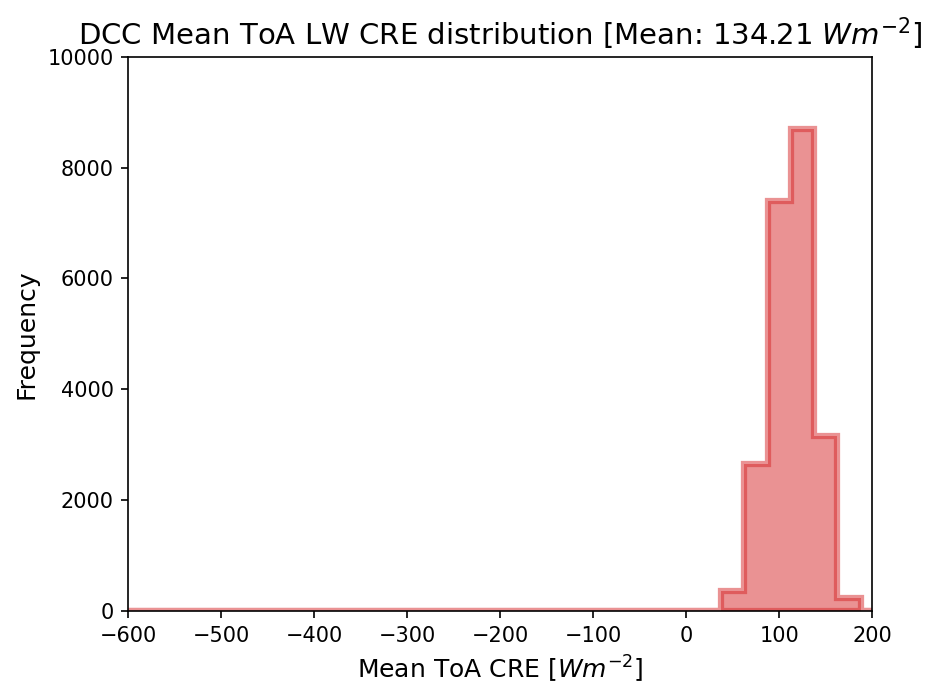

In [346]:
lw_cre = np.concatenate([-ds.thick_anvil_toa_lwup_cre_mean.data for ds in datasets])

plt.figure(dpi=150)
plt.hist(lw_cre[anvil_is_valid], bins=np.arange(-600,226,25)-12.5,  
         alpha=0.5, facecolor = 'C3', edgecolor='C3', ls='solid', lw=3, histtype='stepfilled')
plt.xlim([-600,200])
plt.xlabel("Mean ToA CRE [$Wm^{-2}$]", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.ylim([0,10000])
mean_cre = np.average(lw_cre[anvil_is_valid], weights=anvil_total_area[anvil_is_valid])
plt.title("DCC Mean ToA LW CRE distribution [Mean: %s $Wm^{-2}$]" % str(np.round(mean_cre, 2)), fontsize=14)

Text(0.5, 1.0, 'DCC Mean ToA SW CRE distribution [Mean: -136.07 $Wm^{-2}$]')

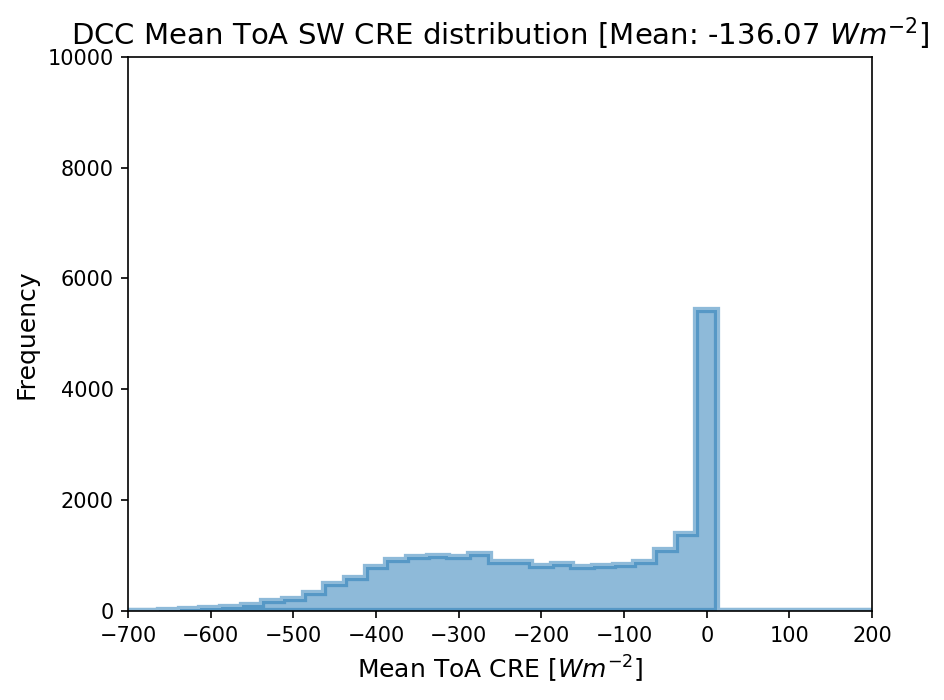

In [347]:
sw_cre = np.concatenate([-ds.thick_anvil_toa_swup_cre_mean.data for ds in datasets])

plt.figure(dpi=150)
plt.hist(sw_cre[anvil_is_valid], bins=np.arange(-700,226,25)-12.5,  
         alpha=0.5, facecolor = 'C0', edgecolor='C0', ls='solid', lw=3, histtype='stepfilled')
plt.xlim([-700,200])
plt.xlabel("Mean ToA CRE [$Wm^{-2}$]", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.ylim([0,10000])
mean_cre = np.average(sw_cre[anvil_is_valid], weights=anvil_total_area[anvil_is_valid])
plt.title("DCC Mean ToA SW CRE distribution [Mean: %s $Wm^{-2}$]" % str(np.round(mean_cre, 2)), fontsize=14)

In [114]:
ctt_mean = np.concatenate([ds.thick_anvil_ctt_mean.data for ds in datasets])

In [115]:
np.quantile(ctt_mean, np.linspace(0,1,11))

array([194.41021729, 220.58159485, 224.50996399, 227.47107544,
       230.05013428, 232.54356384, 235.16391296, 237.97212524,
       241.32914124, 246.23208313, 274.0135498 ])

In [116]:
ctt_bins = [190,215,220,225,230,235,240,245,270]
time_bins = [0,3,6,9,12,15,18,21,24]

ctt_labels = ["<210",215,220,225,230,235,240,245,">250"]

Text(0.5, 1.0, 'Mean anvil CRE')

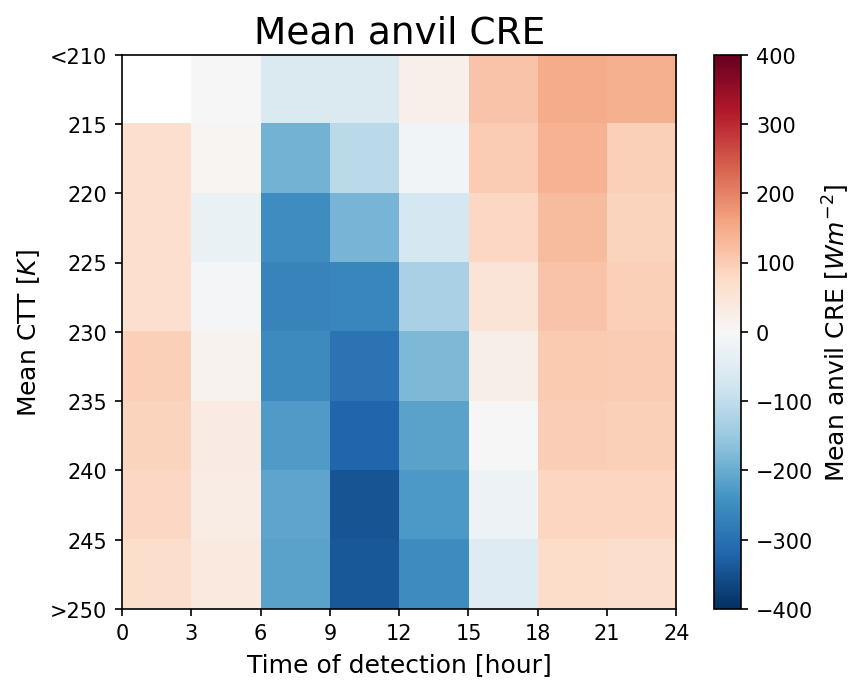

In [348]:
from scipy.stats import binned_statistic_2d

img_data = binned_statistic_2d(
    ctt_mean[anvil_is_valid], 
    anvil_local_hour[anvil_is_valid], 
    net_cre[anvil_is_valid], 
    bins=[ctt_bins, time_bins]
)[0]

plt.figure(dpi=150)
plt.imshow(img_data, cmap="RdBu_r", vmin=-400, vmax=400)
cbar = plt.colorbar()
cbar.set_label("Mean anvil CRE [$Wm^{-2}$]", fontsize=12)

plt.xticks(np.arange(len(time_bins))-0.5, time_bins)
plt.xlabel("Time of detection [hour]", fontsize=12)
plt.yticks(np.arange(len(ctt_bins))-0.5, ctt_labels)
plt.ylabel("Mean CTT [$K$]", fontsize=12)

plt.title("Mean anvil CRE", fontsize=18)

Text(0.5, 1.0, 'Area weighted average anvil CRE')

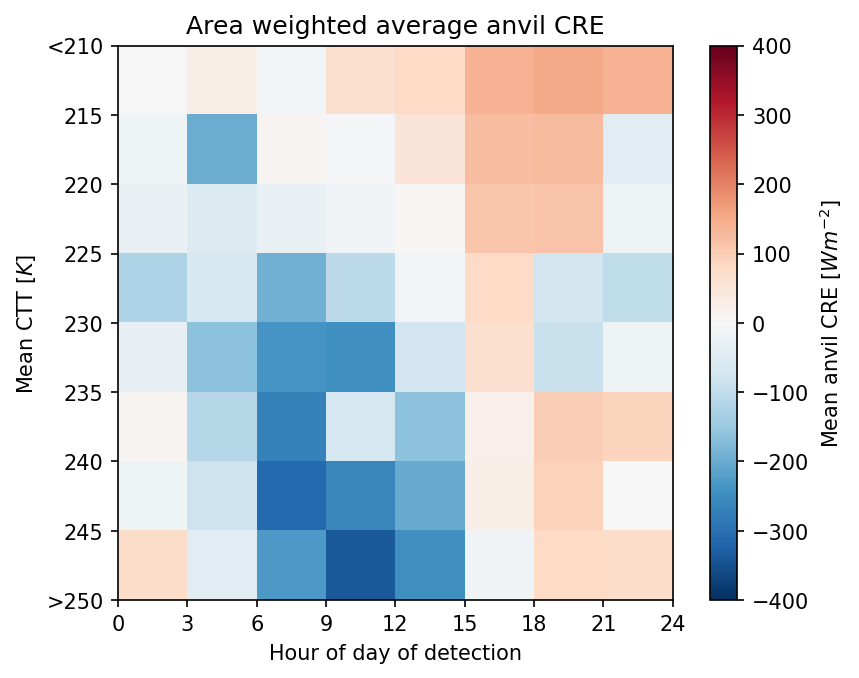

In [349]:
from scipy.stats import binned_statistic_2d

# img_data = binned_statistic_2d(ctt_mean, anvil_local_hour, net_cre, bins=[ctt_bins, time_bins])[0]
plt.figure(dpi=150)

img_data = np.zeros([len(ctt_bins)-1, len(time_bins)-1])

for i in range(len(ctt_bins)-1):
    for j in range(len(time_bins)-1):
        wh = np.logical_and.reduce([
            anvil_is_valid, 
            ctt_mean > ctt_bins[i], 
            ctt_mean <= ctt_bins[i+1], 
            anvil_local_hour > time_bins[j], 
            anvil_local_hour <= time_bins[j+1]
        ])
        if np.any(wh):
            img_data[i,j] = np.average(
                net_cre[wh], 
                weights=anvil_total_area[wh]
            )


plt.imshow(img_data, cmap="RdBu_r", vmin=-400, vmax=400)
plt.colorbar(label="Mean anvil CRE [$Wm^{-2}$]")

plt.xticks(np.arange(len(time_bins))-0.5, time_bins)
plt.xlabel("Hour of day of detection")
plt.yticks(np.arange(len(ctt_bins))-0.5, ctt_labels)
plt.ylabel("Mean CTT [$K$]")

plt.title("Area weighted average anvil CRE")

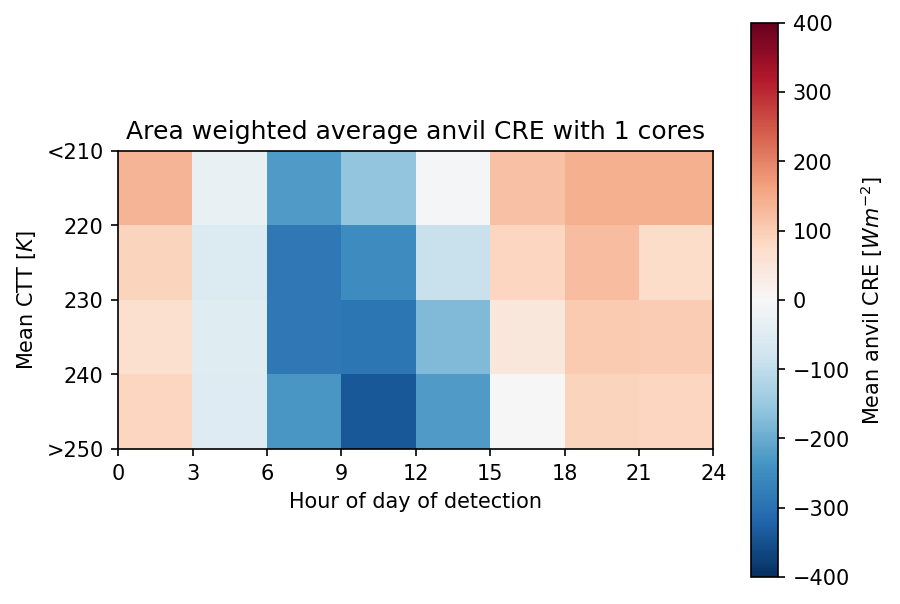

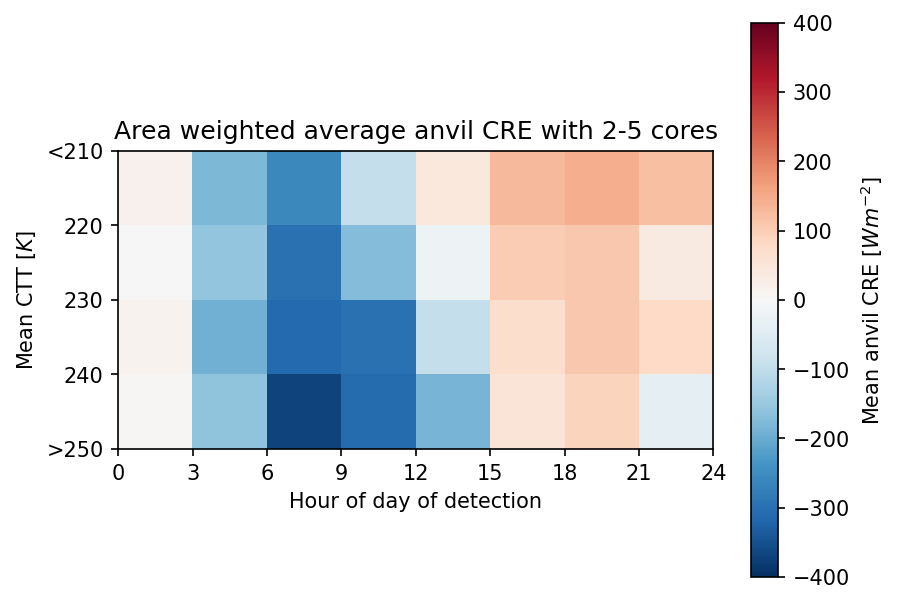

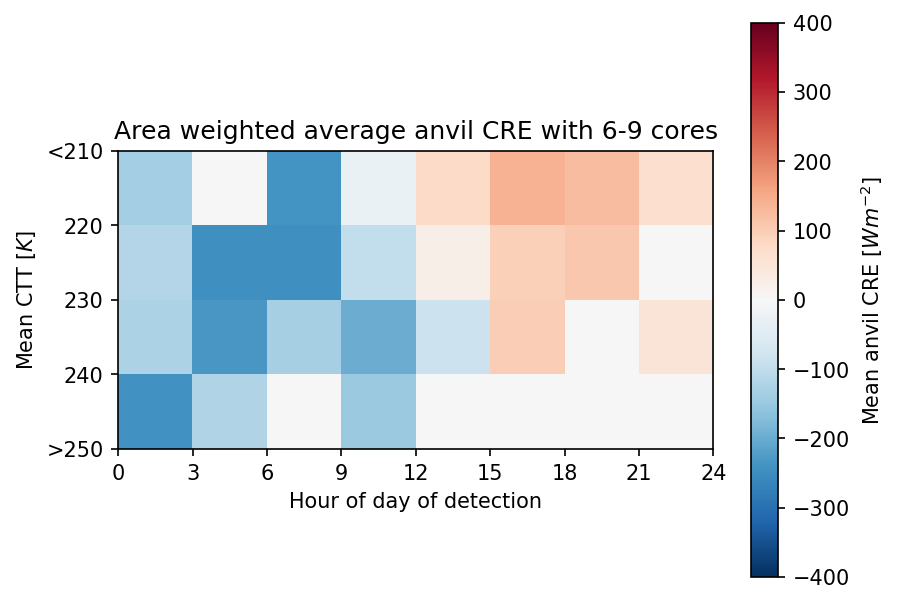

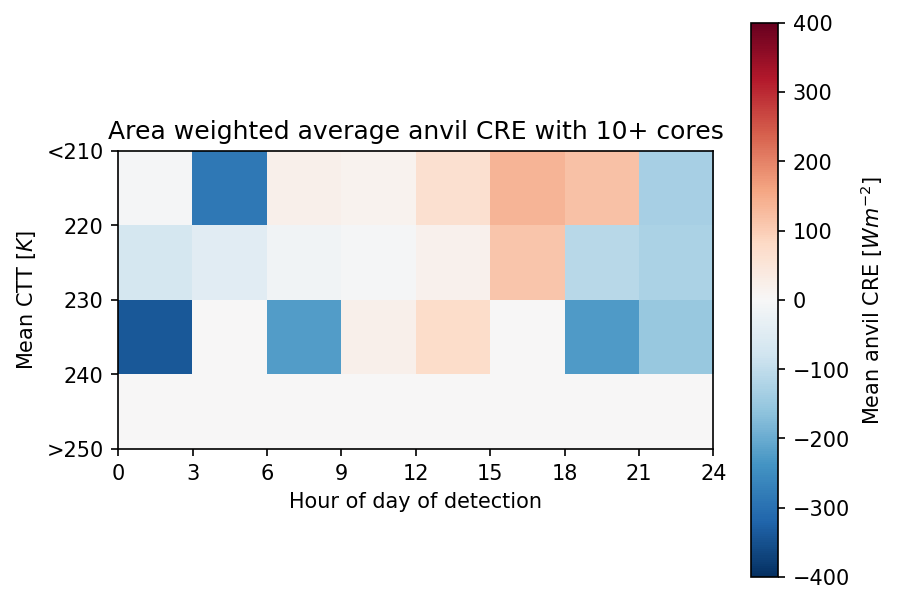

In [350]:
from scipy.stats import binned_statistic_2d
core_bins = [0.5, 1.5, 5.5, 9.5, 999999]
bin_labels = [1, "2-5", "6-9", "10+"]
ctt_bins_reduced = [190,220,230,240,270]
ctt_labels_reduced = ["<210",220,230,240,">250"]

for cn in range(len(core_bins)-1):
    plt.figure(dpi=150)

    img_data = np.zeros([len(ctt_bins_reduced)-1, len(time_bins)-1])


    for i in range(len(ctt_bins_reduced)-1):
        for j in range(len(time_bins)-1):
            wh = np.logical_and.reduce([
                anvil_is_valid, 
                anvil_number_of_cores > core_bins[cn], 
                anvil_number_of_cores < core_bins[cn+1], 
                ctt_mean > ctt_bins_reduced[i], 
                ctt_mean <= ctt_bins_reduced[i+1], 
                anvil_local_hour > time_bins[j], 
                anvil_local_hour <= time_bins[j+1]
            ])
            if np.any(wh):
                img_data[i,j] = np.average(
                    net_cre[wh], 
                    weights=anvil_total_area[wh]
                )


    plt.imshow(img_data, cmap="RdBu_r", vmin=-400, vmax=400)
    plt.colorbar(label="Mean anvil CRE [$Wm^{-2}$]")

    plt.xticks(np.arange(len(time_bins))-0.5, time_bins)
    plt.xlabel("Hour of day of detection")
    plt.yticks(np.arange(len(ctt_bins_reduced))-0.5, ctt_labels_reduced)
    plt.ylabel("Mean CTT [$K$]")

    plt.title(f"Area weighted average anvil CRE with {bin_labels[cn]} cores")

Text(0.5, 1.0, 'Mean CRE of anvils by number of cores')

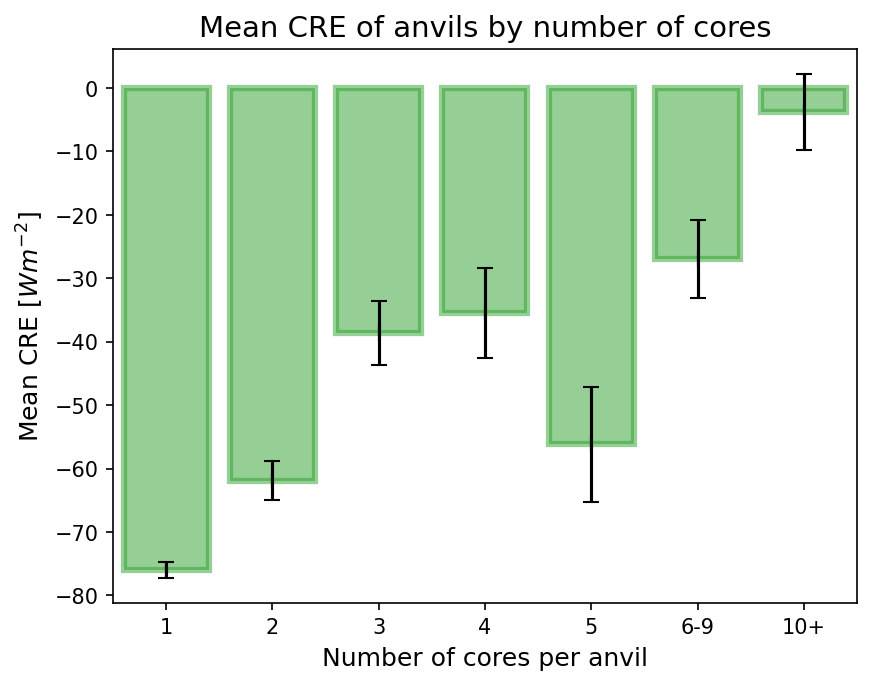

In [351]:
bins = [0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 9.5, 999999]
bin_positions = [1, 2, 3, 4, 5, 6, 7]
bin_labels = [1, 2, 3, 4, 5, "6-9", "10+"]

bar_data = binned_statistic(
    anvil_number_of_cores[anvil_is_valid], 
    net_cre[anvil_is_valid], 
    bins=bins, 
    statistic="mean"
)[0]

errorbar_data = binned_statistic(
    anvil_number_of_cores[anvil_is_valid], 
    net_cre[anvil_is_valid], 
    bins=bins, 
    statistic="std"
)

counts = np.histogram(anvil_number_of_cores[anvil_is_valid], bins=bins)

errorbars = errorbar_data[0] * (counts[0]/(counts[0]-1)) / (counts[0])**0.5

plt.figure(dpi=150)
plt.bar(bin_positions, bar_data, 
        alpha=0.5, facecolor = 'C2', edgecolor='C2', ls='solid', lw=3)
plt.errorbar(bin_positions, bar_data, errorbars, 0, 
             color="k", linestyle="", capsize=4)

plt.xlim([0.5, 7.5])
plt.xticks(bin_positions, bin_labels)
plt.xlabel("Number of cores per anvil",fontsize=12)
plt.ylabel("Mean CRE [$Wm^{-2}$]",fontsize=12)
plt.title("Mean CRE of anvils by number of cores",fontsize=14)

Text(0.5, 1.0, 'Mean CRE of anvils by number of cores')

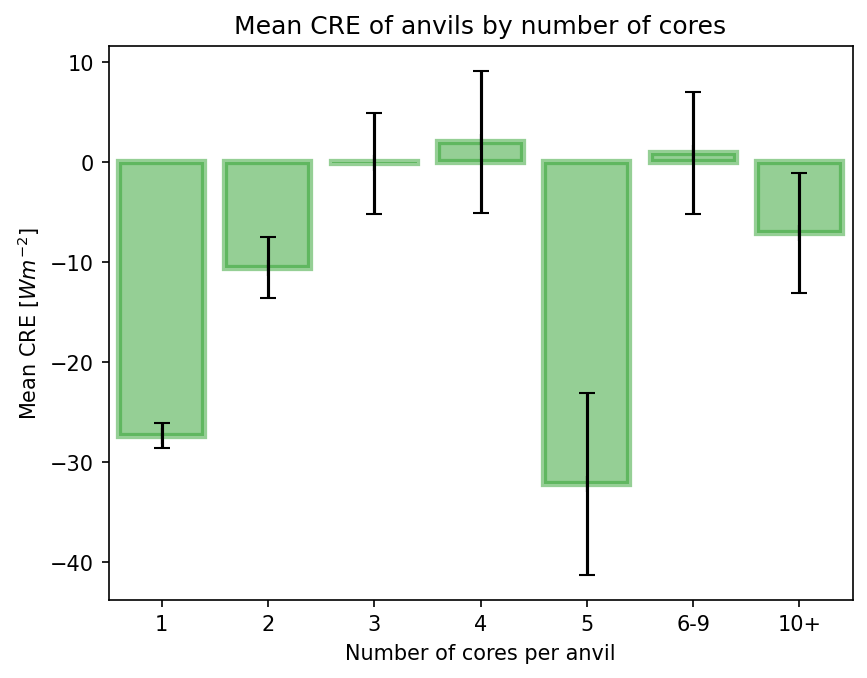

In [352]:
bins = [0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 9.5, 999999]
bin_positions = [1, 2, 3, 4, 5, 6, 7]
bin_labels = [1, 2, 3, 4, 5, "6-9", "10+"]

# bar_data = binned_statistic(
#     anvil_number_of_cores, 
#     net_cre, 
#     bins=bins, 
#     statistic="mean"
# )

counts = np.histogram(anvil_number_of_cores, bins=bins)
bar_data = []
errorbar_data = []
for i in range(1,8):
    if i == 7:
        wh_anvil = anvil_number_of_cores >= 10
    if i == 6:
        wh_anvil = np.logical_and(anvil_number_of_cores>=6, anvil_number_of_cores<=9)
    else:
        wh_anvil = anvil_number_of_cores == i
    wh_anvil = np.logical_and(wh_anvil, anvil_is_valid)
    bar_data.append(np.average(net_cre[wh_anvil], weights=anvil_total_area[wh_anvil]))
    errorbar_data.append(np.std(net_cre[wh_anvil])/counts[0][i-1]**0.5)

# errorbar_data = binned_statistic(
#     anvil_number_of_cores, 
#     net_cre, 
#     bins=bins, 
#     statistic="std"
# )

# counts = np.histogram(anvil_number_of_cores, bins=bins)

# errorbars = errorbar_data[0] * (counts[0]/(counts[0]-1)) / (counts[0])**0.5

plt.figure(dpi=150)
plt.bar(bin_positions, bar_data, 
        alpha=0.5, facecolor = 'C2', edgecolor='C2', ls='solid', lw=3)
plt.errorbar(bin_positions, bar_data, errorbars, 0, 
             color="k", linestyle="", capsize=4)

plt.xlim([0.5, 7.5])
plt.xticks(bin_positions, bin_labels)
plt.xlabel("Number of cores per anvil")
plt.ylabel("Mean CRE [$Wm^{-2}$]")
plt.title("Mean CRE of anvils by number of cores")

Text(0.5, 1.0, 'DCC Mean ToA SW CRE distribution [Mean: -137.14 $Wm^{-2}$]')

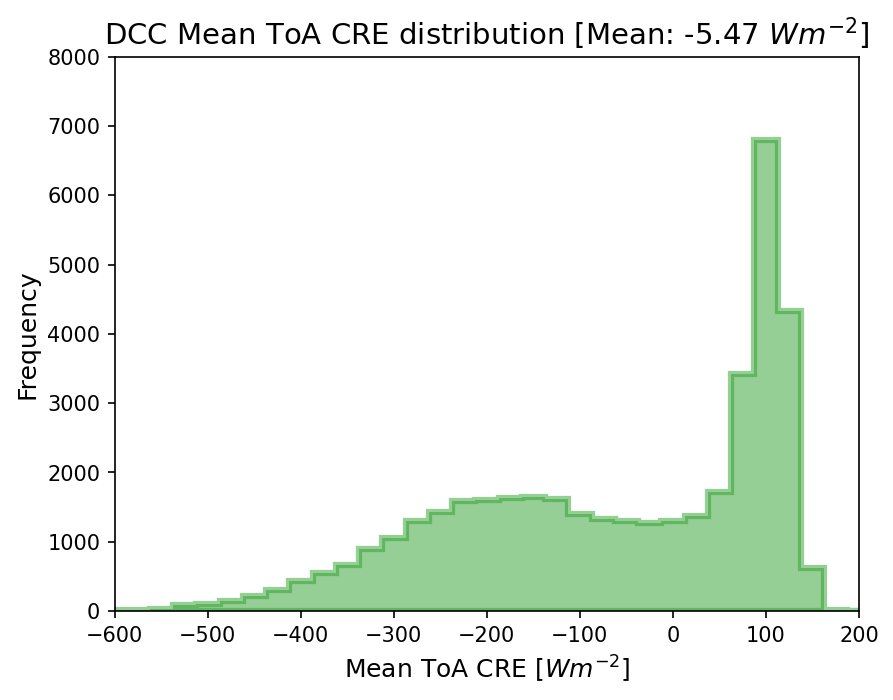

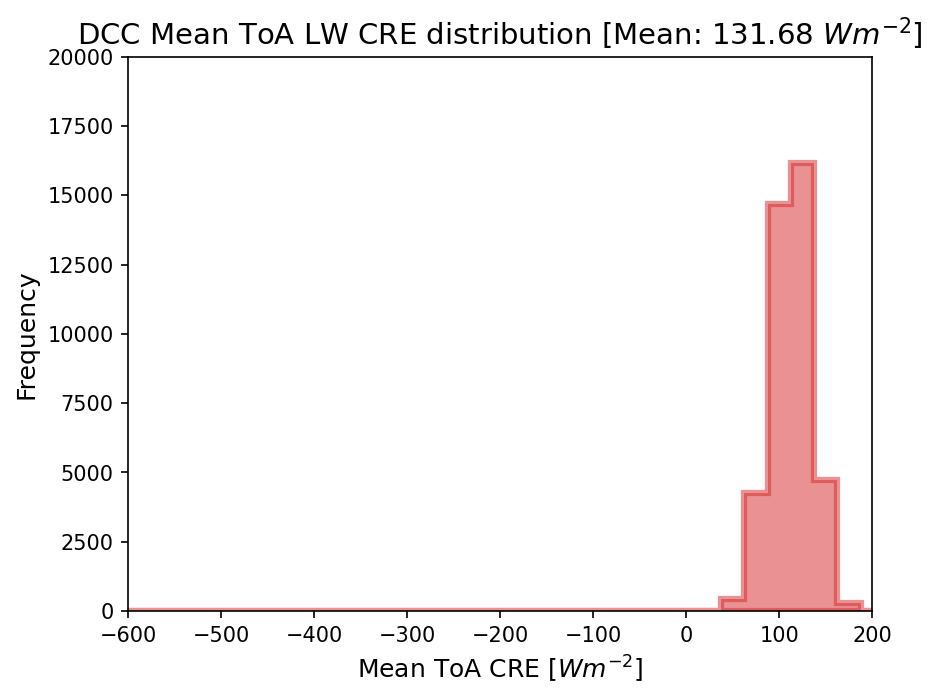

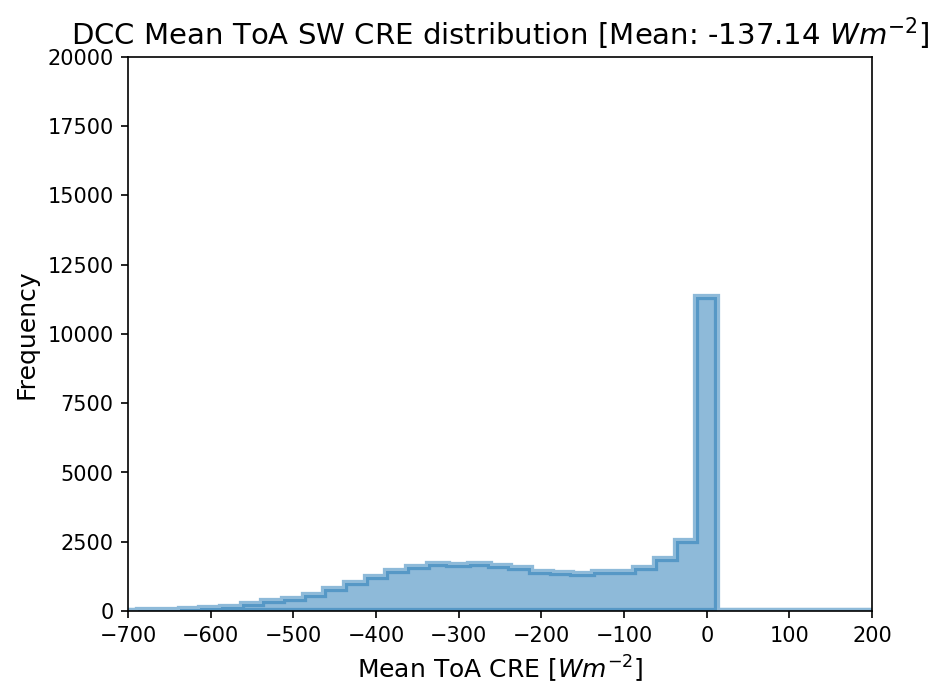

In [125]:
thin_anvil_net_cre = np.concatenate([ds.thin_anvil_toa_cre_mean.data for ds in datasets])
thin_anvil_lw_cre = np.concatenate([-ds.thin_anvil_toa_lwup_cre_mean.data for ds in datasets])
thin_anvil_sw_cre = np.concatenate([-ds.thin_anvil_toa_swup_cre_mean.data for ds in datasets])

thin_anvil_total_area = np.concatenate([ds.thick_anvil_total_area.data for ds in datasets])/4

thin_anvil_is_valid = np.concatenate([ds.thin_anvil_is_valid.data for ds in datasets])
thin_anvil_is_valid = np.logical_and(thin_anvil_is_valid, np.isfinite(thin_anvil_net_cre))
np.sum(thin_anvil_is_valid), thin_anvil_is_valid.size

plt.figure(dpi=150)
plt.hist(thin_anvil_net_cre[anvil_is_valid], bins=np.arange(-600,226,25)-12.5,  
         alpha=0.5, facecolor = 'C2', edgecolor='C2', ls='solid', lw=3, histtype='stepfilled')
plt.xlim([-600,200])
plt.xlabel("Mean ToA CRE [$Wm^{-2}$]", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.ylim([0,8000])
mean_cre = np.average(
    thin_anvil_net_cre[thin_anvil_is_valid], 
    weights=thin_anvil_total_area[thin_anvil_is_valid]
)
plt.title("DCC Mean ToA CRE distribution [Mean: %s $Wm^{-2}$]" % str(np.round(mean_cre, 2)), fontsize=14)


plt.figure(dpi=150)
plt.hist(thin_anvil_lw_cre[thin_anvil_is_valid], bins=np.arange(-600,226,25)-12.5,  
         alpha=0.5, facecolor = 'C3', edgecolor='C3', ls='solid', lw=3, histtype='stepfilled')
plt.xlim([-600,200])
plt.xlabel("Mean ToA CRE [$Wm^{-2}$]", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.ylim([0,20000])
mean_cre = np.average(thin_anvil_lw_cre[thin_anvil_is_valid], weights=thin_anvil_total_area[thin_anvil_is_valid])
plt.title("DCC Mean ToA LW CRE distribution [Mean: %s $Wm^{-2}$]" % str(np.round(mean_cre, 2)), fontsize=14)


plt.figure(dpi=150)
plt.hist(thin_anvil_sw_cre[thin_anvil_is_valid], bins=np.arange(-700,226,25)-12.5,  
         alpha=0.5, facecolor = 'C0', edgecolor='C0', ls='solid', lw=3, histtype='stepfilled')
plt.xlim([-700,200])
plt.xlabel("Mean ToA CRE [$Wm^{-2}$]", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.ylim([0,20000])
mean_cre = np.average(thin_anvil_sw_cre[thin_anvil_is_valid], weights=thin_anvil_total_area[thin_anvil_is_valid])
plt.title("DCC Mean ToA SW CRE distribution [Mean: %s $Wm^{-2}$]" % str(np.round(mean_cre, 2)), fontsize=14)

In [74]:
np.average?

In [42]:
pd.date_range?

In [73]:
time_bins_6hr = pd.date_range(datetime(2016,5,1), datetime(2016,8,1), freq="6H")
time_bins = pd.date_range(datetime(2016,5,1), datetime(2016,8,1), freq="1D")
lon_bins = np.arange(-19, 48)

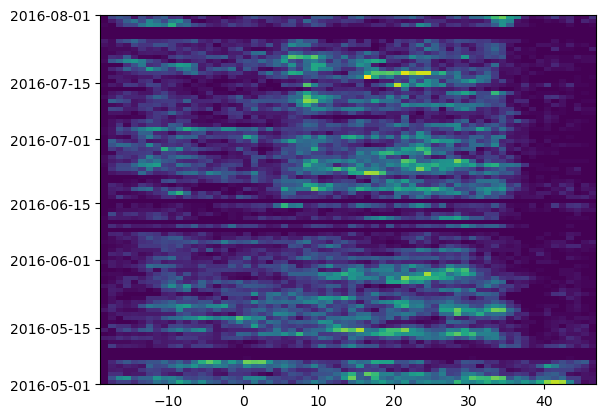

In [53]:
h = plt.hist2d(core_start_lon, core_start_t, bins=[lon_bins, time_bins])

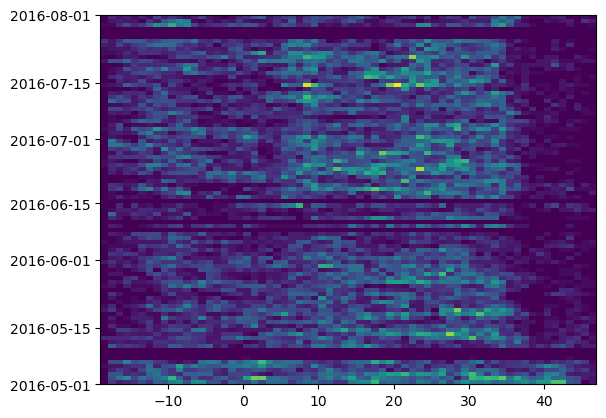

In [51]:
h = plt.hist2d(anvil_start_lon, anvil_start_t, bins=[lon_bins, time_bins])

In [54]:
anvil_step_lat = np.concatenate([ds.thick_anvil_step_lat.data for ds in datasets])
anvil_step_lon = np.concatenate([ds.thick_anvil_step_lon.data for ds in datasets])
anvil_step_t = np.concatenate([ds.thick_anvil_step_t.data for ds in datasets])


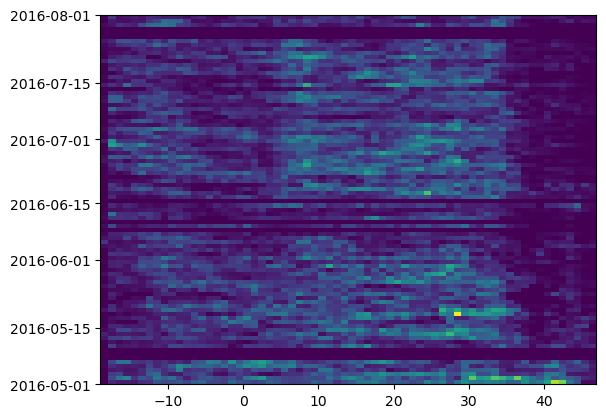

In [55]:
h = plt.hist2d(anvil_step_lon, anvil_step_t, bins=[lon_bins, time_bins])

In [56]:
anvil_step_area = np.concatenate([ds.thick_anvil_step_area.data for ds in datasets])


In [75]:
doy = lambda t_list : np.array([(t-datetime(t.year,1,1)).total_seconds()/86400 + 1 for t in t_list])

In [76]:
pd.to_datetime(anvil_step_t).to_pydatetime()

array([datetime.datetime(2016, 5, 1, 0, 0),
       datetime.datetime(2016, 5, 1, 0, 0),
       datetime.datetime(2016, 5, 1, 0, 0), ...,
       datetime.datetime(2016, 8, 30, 23, 45),
       datetime.datetime(2016, 8, 30, 23, 45),
       datetime.datetime(2016, 8, 30, 23, 45)], dtype=object)

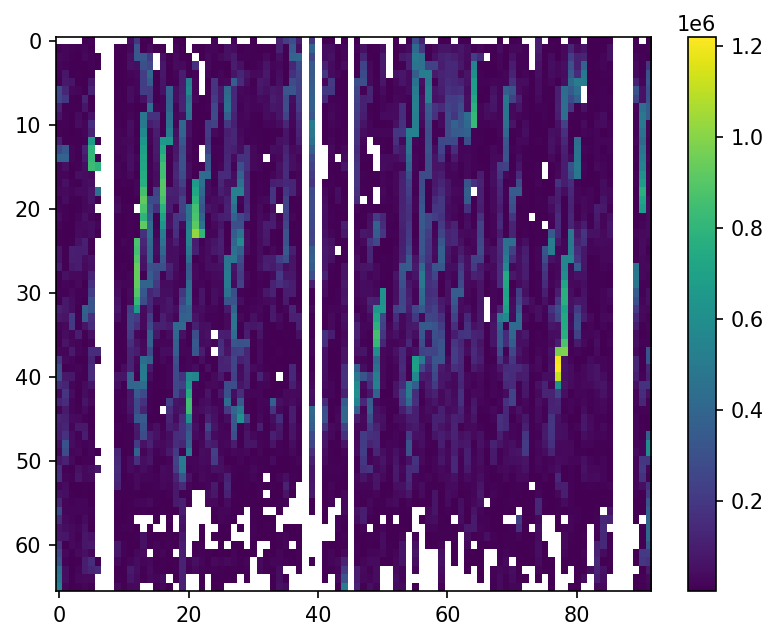

In [79]:
img_data = binned_statistic_2d(anvil_step_lon, doy(pd.to_datetime(anvil_step_t).to_pydatetime()), anvil_step_area, bins=[lon_bins, doy(time_bins)], statistic="max")[0]

plt.figure(dpi=150)
plt.imshow(img_data, aspect="auto")
cbar = plt.colorbar()

# plt.xticks(range(len(time_bins)), labels=time_bins)

In [80]:
anvil_step_cre = np.concatenate([ds.thick_anvil_step_toa_cre_mean.data for ds in datasets])


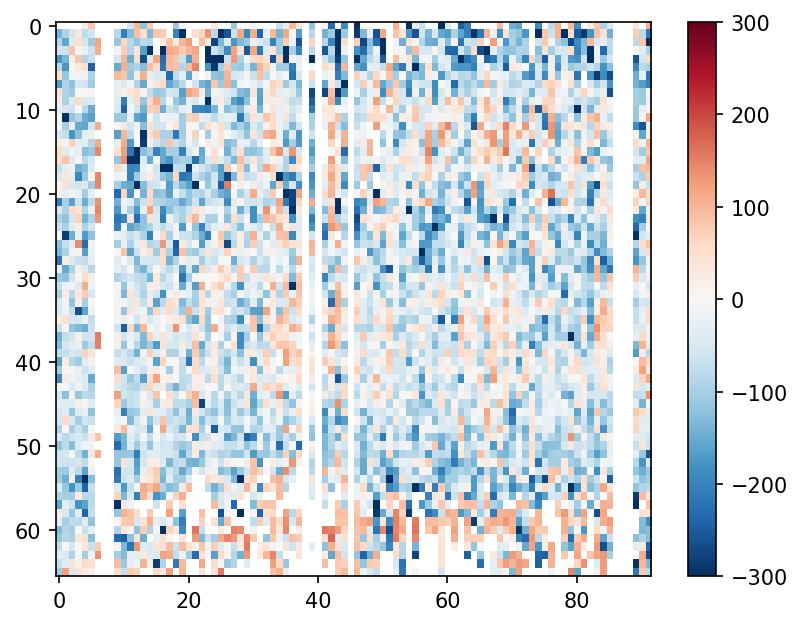

In [82]:
img_data = binned_statistic_2d(anvil_step_lon, doy(pd.to_datetime(anvil_step_t).to_pydatetime()), anvil_step_cre, bins=[lon_bins, doy(time_bins)], statistic="mean")[0]

plt.figure(dpi=150)
plt.imshow(img_data, aspect="auto",cmap="RdBu_r",vmin=-300,vmax=300)
cbar = plt.colorbar()

# plt.xticks(range(len(time_bins)), labels=time_bins)

/tmp/ipykernel_46402/4236639016.py:2: RuntimeWarning: invalid value encountered in divide
  img_data /= binned_statistic_2d(anvil_step_lon, doy(pd.to_datetime(anvil_step_t).to_pydatetime()), anvil_step_area, bins=[lon_bins, doy(time_bins)], statistic="sum")[0]


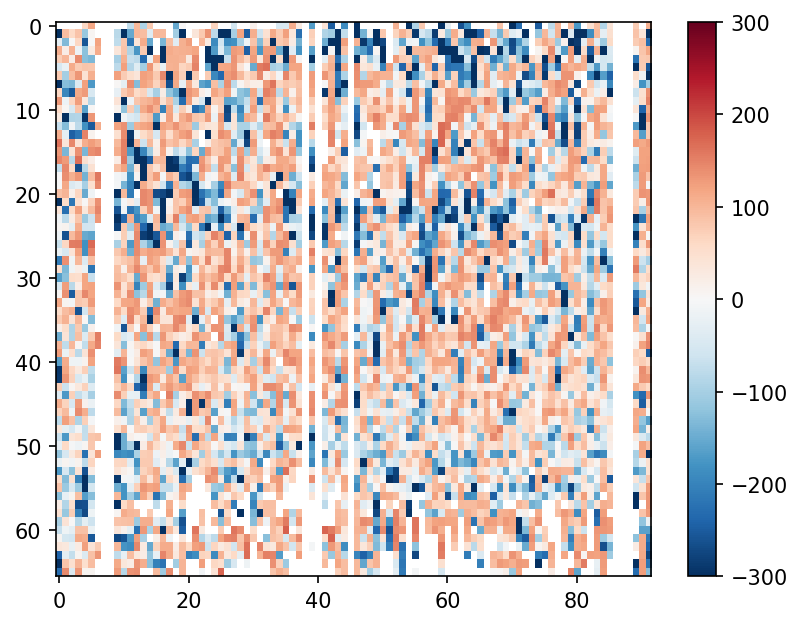

In [85]:
img_data = binned_statistic_2d(anvil_step_lon, doy(pd.to_datetime(anvil_step_t).to_pydatetime()), anvil_step_cre*anvil_step_area, bins=[lon_bins, doy(time_bins)], statistic="sum")[0]
img_data /= binned_statistic_2d(anvil_step_lon, doy(pd.to_datetime(anvil_step_t).to_pydatetime()), anvil_step_area, bins=[lon_bins, doy(time_bins)], statistic="sum")[0]

plt.figure(dpi=150)
plt.imshow(img_data, aspect="auto",cmap="RdBu_r",vmin=-300,vmax=300)
cbar = plt.colorbar()

# plt.xticks(range(len(time_bins)), labels=time_bins)

Text(0.5, 1.0, 'DCC Mean ToA CRE map')

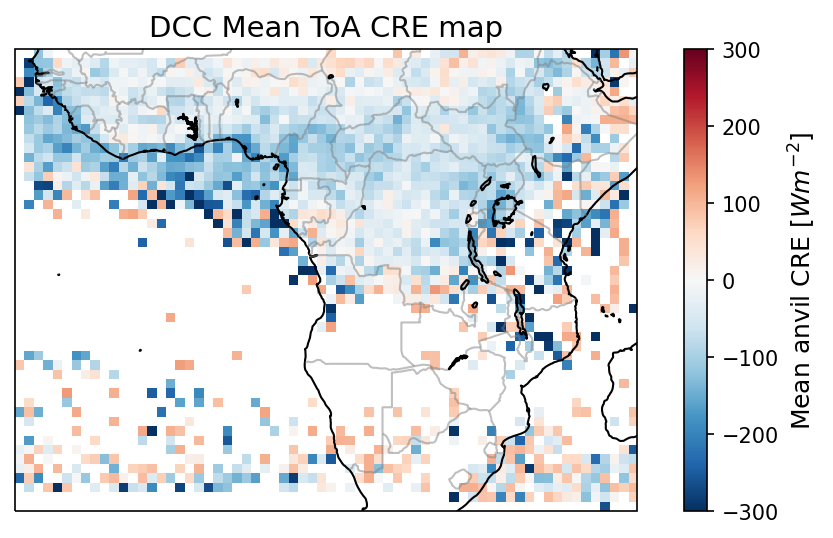

In [162]:
fig = plt.figure(dpi=150, figsize=(8,4))

ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()
ax.add_feature(cfeature.BORDERS, edgecolor='gray', alpha=0.5)
ax.add_feature(cfeature.LAKES, edgecolor='black', alpha=1, facecolor="none")

from scipy.stats import binned_statistic_2d, circmean

img_data = binned_statistic_2d(anvil_start_lon[anvil_is_valid], 
                               anvil_start_lat[anvil_is_valid], 
                               net_cre[anvil_is_valid], 
                               bins=[np.arange(img_extent[0],img_extent[1]+1), 
                                     np.arange(img_extent[2],img_extent[3]+1)], 
                               statistic="mean")
img = ax.imshow(img_data[0].T[::-1], extent=img_extent,cmap="RdBu_r",vmin=-300,vmax=300)

cbar = plt.colorbar(img)
cbar.set_label("Mean anvil CRE [$Wm^{-2}$]", fontsize=12)

plt.title("DCC Mean ToA CRE map", fontsize=14)

Text(0.5, 1.0, 'DCC Mean CTT map')

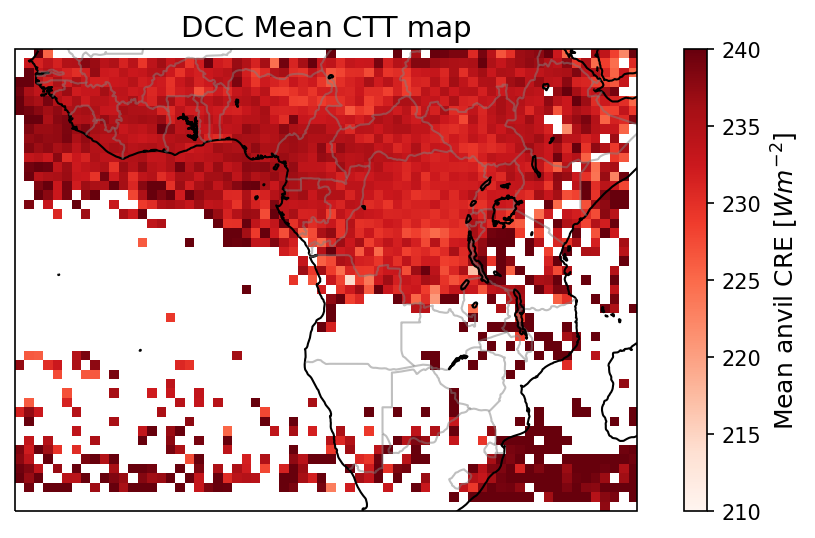

In [167]:
fig = plt.figure(dpi=150, figsize=(8,4))

ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()
ax.add_feature(cfeature.BORDERS, edgecolor='gray', alpha=0.5)
ax.add_feature(cfeature.LAKES, edgecolor='black', alpha=1, facecolor="none")

from scipy.stats import binned_statistic_2d, circmean

img_data = binned_statistic_2d(anvil_start_lon[anvil_is_valid], 
                               anvil_start_lat[anvil_is_valid], 
                               ctt_mean[anvil_is_valid], 
                               bins=[np.arange(img_extent[0],img_extent[1]+1), 
                                     np.arange(img_extent[2],img_extent[3]+1)], 
                               statistic="mean")
img = ax.imshow(img_data[0].T[::-1], extent=img_extent,cmap="Reds",vmin=210,vmax=240)

cbar = plt.colorbar(img)
cbar.set_label("Mean anvil CRE [$Wm^{-2}$]", fontsize=12)

plt.title("DCC Mean CTT map", fontsize=14)

/tmp/ipykernel_8624/2769405951.py:16: RuntimeWarning: invalid value encountered in divide
  img_data /= binned_statistic_2d(anvil_start_lon[anvil_is_valid],


Text(0.5, 1.0, 'DCC Mean ToA CRE map')

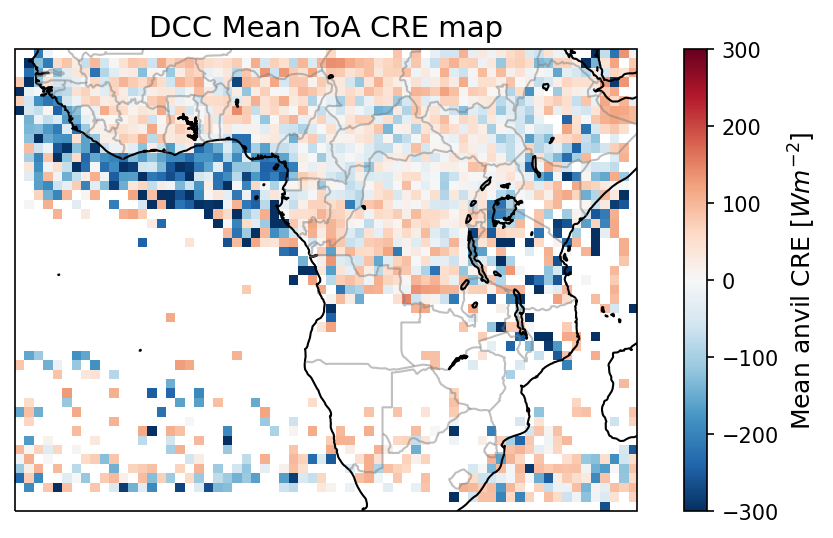

In [163]:
fig = plt.figure(dpi=150, figsize=(8,4))

ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()
ax.add_feature(cfeature.BORDERS, edgecolor='gray', alpha=0.5)
ax.add_feature(cfeature.LAKES, edgecolor='black', alpha=1, facecolor="none")

from scipy.stats import binned_statistic_2d, circmean

img_data = binned_statistic_2d(anvil_start_lon[anvil_is_valid], 
                               anvil_start_lat[anvil_is_valid], 
                               net_cre[anvil_is_valid]*anvil_total_area[anvil_is_valid], 
                               bins=[np.arange(img_extent[0],img_extent[1]+1), 
                                     np.arange(img_extent[2],img_extent[3]+1)], 
                               statistic="sum")[0]
img_data /= binned_statistic_2d(anvil_start_lon[anvil_is_valid], 
                                anvil_start_lat[anvil_is_valid], 
                                anvil_total_area[anvil_is_valid], 
                                bins=[np.arange(img_extent[0],img_extent[1]+1), 
                                      np.arange(img_extent[2],img_extent[3]+1)], 
                                statistic="sum")[0]
img = ax.imshow(img_data.T[::-1], extent=img_extent,cmap="RdBu_r",vmin=-300,vmax=300)

cbar = plt.colorbar(img)
cbar.set_label("Mean anvil CRE [$Wm^{-2}$]", fontsize=12)

plt.title("DCC Mean ToA CRE map", fontsize=14)

/tmp/ipykernel_8624/3441838539.py:16: RuntimeWarning: invalid value encountered in divide
  img_data /= binned_statistic_2d(anvil_start_lon[anvil_is_valid],


Text(0.5, 1.0, 'DCC Mean CTT map')

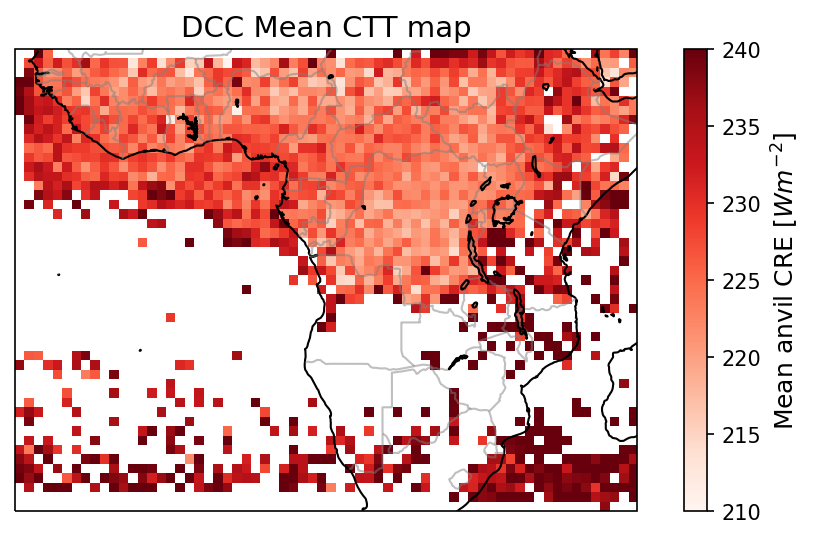

In [168]:
fig = plt.figure(dpi=150, figsize=(8,4))

ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()
ax.add_feature(cfeature.BORDERS, edgecolor='gray', alpha=0.5)
ax.add_feature(cfeature.LAKES, edgecolor='black', alpha=1, facecolor="none")

from scipy.stats import binned_statistic_2d, circmean

img_data = binned_statistic_2d(anvil_start_lon[anvil_is_valid], 
                               anvil_start_lat[anvil_is_valid], 
                               ctt_mean[anvil_is_valid]*anvil_total_area[anvil_is_valid], 
                               bins=[np.arange(img_extent[0],img_extent[1]+1), 
                                     np.arange(img_extent[2],img_extent[3]+1)], 
                               statistic="sum")[0]
img_data /= binned_statistic_2d(anvil_start_lon[anvil_is_valid], 
                                anvil_start_lat[anvil_is_valid], 
                                anvil_total_area[anvil_is_valid], 
                                bins=[np.arange(img_extent[0],img_extent[1]+1), 
                                      np.arange(img_extent[2],img_extent[3]+1)], 
                                statistic="sum")[0]
img = ax.imshow(img_data.T[::-1], extent=img_extent,cmap="Reds",vmin=210,vmax=240)

cbar = plt.colorbar(img)
cbar.set_label("Mean anvil CRE [$Wm^{-2}$]", fontsize=12)

plt.title("DCC Mean CTT map", fontsize=14)

NameError: name 'anvil_step_lon' is not defined

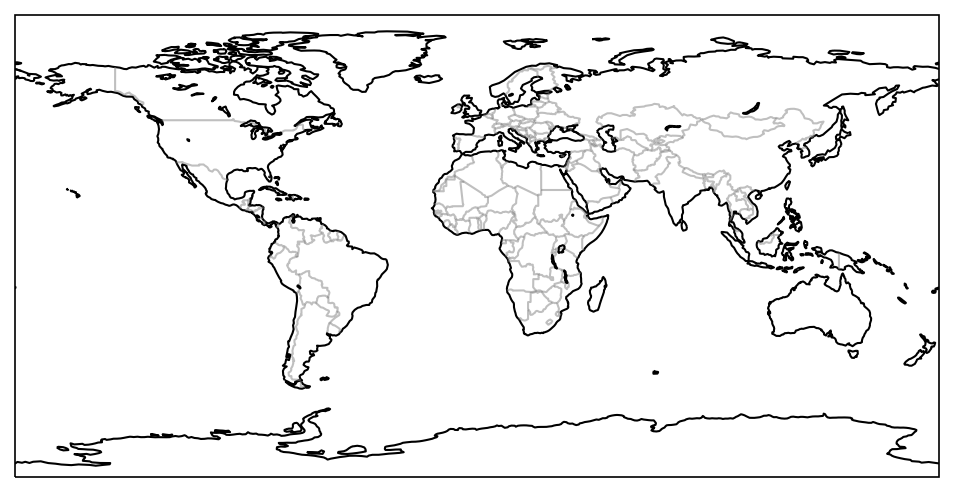

In [130]:
fig = plt.figure(dpi=150, figsize=(8,4))

ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()
ax.add_feature(cfeature.BORDERS, edgecolor='gray', alpha=0.5)
ax.add_feature(cfeature.LAKES, edgecolor='black', alpha=1, facecolor="none")

from scipy.stats import binned_statistic_2d, circmean

img_data = binned_statistic_2d(anvil_step_lon, anvil_step_lat, anvil_step_cre, 
                               bins=[np.arange(img_extent[0],img_extent[1]+1), 
                                     np.arange(img_extent[2],img_extent[3]+1)], 
                               statistic="mean")
img = ax.imshow(img_data[0].T[::-1], extent=img_extent,cmap="RdBu_r",vmin=-300,vmax=300)

cbar = plt.colorbar(img)
cbar.set_label("Mean anvil CRE [$Wm^{-2}$]", fontsize=12)

plt.title("DCC Mean ToA CRE map", fontsize=14)

/tmp/ipykernel_46402/1886377371.py:14: RuntimeWarning: invalid value encountered in divide
  img_data /= binned_statistic_2d(anvil_step_lon, anvil_step_lat, anvil_step_area,


Text(0.5, 1.0, 'DCC Mean ToA CRE map')

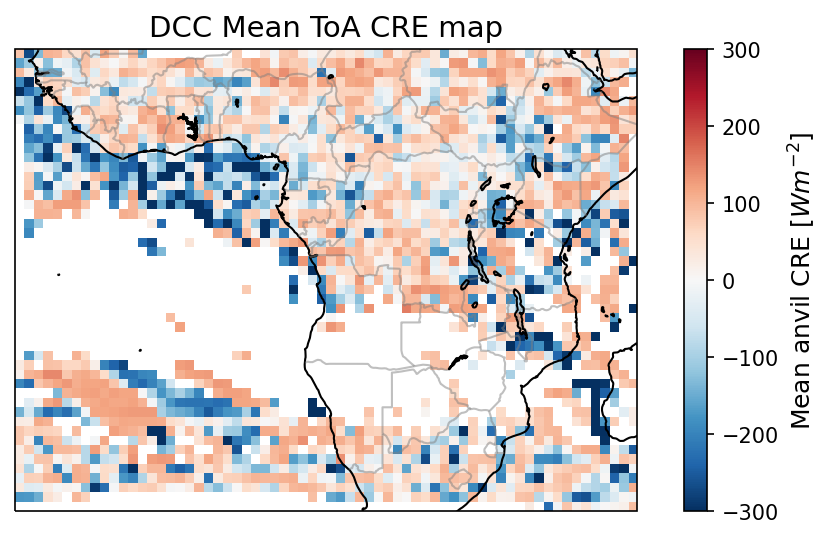

In [93]:
fig = plt.figure(dpi=150, figsize=(8,4))

ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()
ax.add_feature(cfeature.BORDERS, edgecolor='gray', alpha=0.5)
ax.add_feature(cfeature.LAKES, edgecolor='black', alpha=1, facecolor="none")

from scipy.stats import binned_statistic_2d, circmean

img_data = binned_statistic_2d(anvil_step_lon, anvil_step_lat, anvil_step_cre*anvil_step_area, 
                               bins=[np.arange(img_extent[0],img_extent[1]+1), 
                                     np.arange(img_extent[2],img_extent[3]+1)], 
                               statistic="sum")[0]
img_data /= binned_statistic_2d(anvil_step_lon, anvil_step_lat, anvil_step_area, 
                               bins=[np.arange(img_extent[0],img_extent[1]+1), 
                                     np.arange(img_extent[2],img_extent[3]+1)], 
                               statistic="sum")[0]
img = ax.imshow(img_data.T[::-1], extent=img_extent,cmap="RdBu_r",vmin=-300,vmax=300)

cbar = plt.colorbar(img)
cbar.set_label("Mean anvil CRE [$Wm^{-2}$]", fontsize=12)

plt.title("DCC Mean ToA CRE map", fontsize=14)

In [16]:
img_extent

(-19, 47, -33, 16)

In [15]:
img_data[0].shape

(66, 49)

In [123]:
test = [da[1].rolling(thick_anvil_step=5, center=True, min_periods=3).reduce(np.nanmean) for da in datasets[0].thick_anvil_step_lon.groupby(datasets[0].thick_anvil_step_anvil_index)]

In [125]:
smoothed_anvil_lon = [da[1].rolling(thick_anvil_step=5, center=True, min_periods=3).reduce(np.nanmean) for da in datasets[0].thick_anvil_step_lon.groupby(datasets[0].thick_anvil_step_anvil_index)]
smoothed_anvil_lat = [da[1].rolling(thick_anvil_step=5, center=True, min_periods=3).reduce(np.nanmean) for da in datasets[0].thick_anvil_step_lat.groupby(datasets[0].thick_anvil_step_anvil_index)]

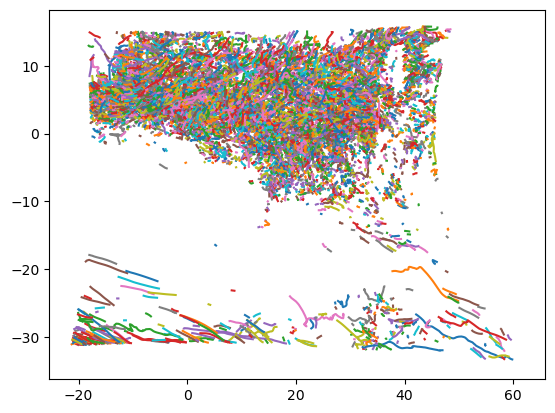

In [131]:
for i in range(len(smoothed_anvil_lon)):
# for i in range(1000):
    plt.plot(smoothed_anvil_lon[i], smoothed_anvil_lat[i])